In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import warnings

warnings.simplefilter("ignore")
conn = sqlite3.connect('database.sqlite')

# посмотрим какие таблице присутствуют в БД
tables = pd.read_sql("""SELECT *                           
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [2]:
# создаём переменные для каждой таблицы
Country = pd.read_sql_query("SELECT * from Country", conn)
League = pd.read_sql_query("SELECT * from League", conn)
Match = pd.read_sql_query("SELECT * from Match", conn)
Team = pd.read_sql_query("SELECT * from Team",conn)
Player = pd.read_sql_query("SELECT * from Player",conn)
Team_Attributes = pd.read_sql_query("SELECT * from Team_Attributes",conn)
Player_Attributes = pd.read_sql_query("SELECT * from Player_Attributes",conn)

In [3]:
# убираем неиспользуемые столбцы в таблице Match
match = Match.copy()
match.drop(Match.columns[
    [2,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
     38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,
     65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
     92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114]], axis= 1 , inplace= True)
Country.rename(columns = {'id':'country_id', 'name':'country'}, inplace = True)
League.rename(columns = {'name':'league'}, inplace = True)
League.drop(League.columns[[0]], axis= 1 , inplace= True) 
league = Country.merge(League, left_on='country_id', right_on='country_id', how='outer')

In [4]:
# убираем неиспользуемые столбцы в таблице Team
Team.drop(Team.columns[[0,2,4]], axis=1, inplace= True)
team_AT = Team.copy()
team_AT.rename(columns = {'team_long_name':'away_team_name'}, inplace = True)
team_HT = Team.copy()
team_HT.rename(columns = {'team_long_name':'home_team_name',}, inplace = True)

In [5]:
# посчитаем кол-во выиграшей, ничьих и поражений для команд
match = match.merge(league, left_on='country_id', right_on='country_id', how='left')
match = match.merge(team_HT, left_on='home_team_api_id', right_on='team_api_id', how='left')
match = match.merge(team_AT, left_on='away_team_api_id', right_on='team_api_id', how='left')
match.drop(match.columns[[6,7,12,14]], axis= 1 , inplace= True)
def wdl(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 'Win'
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 'Draw'
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 'Away Win'
    return val

match['match summary'] = match.apply (wdl, axis=1)
match_summary = pd.get_dummies(match['match summary'])
match = pd.concat([match, match_summary], axis = 1)
match

,id,country_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,country,league,home_team_name,away_team_name,match summary,Away Win,Draw,Win
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,1,1,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC,Draw,0,1,0
1,2,1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren,Draw,0,1,0
2,3,1,2008/2009,1,2008-08-16 00:00:00,492475,0,3,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht,Away Win,1,0,0
3,4,1,2008/2009,1,2008-08-17 00:00:00,492476,5,0,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons,Win,0,0,1
4,5,1,2008/2009,1,2008-08-16 00:00:00,492477,1,3,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège,Away Win,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,2015/2016,9,2015-09-22 00:00:00,1992091,1,0,Switzerland,Switzerland Super League,FC St. Gallen,FC Thun,Win,0,0,1
25975,25976,24558,2015/2016,9,2015-09-23 00:00:00,1992092,1,2,Switzerland,Switzerland Super League,FC Vaduz,FC Luzern,Away Win,1,0,0
25976,25977,24558,2015/2016,9,2015-09-23 00:00:00,1992093,2,0,Switzerland,Switzerland Super League,Grasshopper Club Zürich,FC Sion,Win,0,0,1
25977,25978,24558,2015/2016,9,2015-09-22 00:00:00,1992094,0,0,Switzerland,Switzerland Super League,Lugano,FC Zürich,Draw,0,1,0


In [6]:
# скомпонуем статистику в удобную таблицу
produces = match[['home_team_name','away_team_name','home_team_goal','away_team_goal', 'league','match summary']].copy()
MSHwin_count = produces.groupby('home_team_name')['match summary'].apply ( lambda x: (x=='Win'). sum ()). reset_index(name='Home Win').copy()
MSAwin_count = produces.groupby('away_team_name')['match summary'].apply ( lambda x: (x=='Away Win'). sum ()). reset_index(name='Away Win').copy()
MSHDraw_count = produces.groupby('home_team_name')['match summary'].apply ( lambda x: (x=='Draw'). sum ()). reset_index(name='Home Draw').copy()
MSAD_count = produces.groupby('away_team_name')['match summary'].apply ( lambda x: (x=='Draw'). sum ()). reset_index(name='Away Draw').copy()
LH_count = produces.groupby(['home_team_name'])['match summary'].apply ( lambda x: (x=='Away Win'). sum ()). reset_index(name='Home Lose').copy()
LA_count = produces.groupby(['away_team_name'])['match summary'].apply ( lambda x: (x=='Win'). sum ()). reset_index(name='Away Lose').copy()
team_data = MSHwin_count.merge(MSHDraw_count, left_on='home_team_name', right_on='home_team_name', how='left')
team_data = team_data.merge(MSAwin_count, left_on='home_team_name', right_on='away_team_name', how='left')
team_data = team_data.merge(MSAD_count, left_on='home_team_name', right_on='away_team_name', how='left')
team_data = team_data.merge(LH_count, left_on='home_team_name', right_on='home_team_name', how='left')
team_data = team_data.merge(LA_count, left_on='home_team_name', right_on='away_team_name', how='left')
team_data = team_data.merge(produces, left_on='home_team_name', right_on='away_team_name', how='left')
team_data.drop(team_data.columns[[3,5,8,10,11,12,13]], axis= 1 , inplace= True)
team_data.rename(columns = {'home_team_name_x':'home_team_name'}, inplace = True)
team_data = team_data[['home_team_name', 'league','Home Win','Home Draw', 'Home Lose','Away Win','Away Draw','Away Lose','match summary']]
#team_data 

In [7]:
# посчитаем количество голов
HGC = produces.groupby(['home_team_name'])['home_team_goal']. sum().copy()    # кол-во забитых голов в домашних матчах
AGC = produces.groupby(['away_team_name'])['away_team_goal']. sum().copy()    # кол-во забитых голов в гостевых матчах
HFGC = produces.groupby(['home_team_name'])['away_team_goal']. sum().copy()   # кол-во пропущенных голов в домашних матчах
AFGC = produces.groupby(['away_team_name'])['home_team_goal']. sum().copy()   # кол-во пропущенных голов в гостевых матчах
team_data = team_data.merge(HGC, left_on='home_team_name', right_on='home_team_name', how='left')
team_data = team_data.merge(AGC, left_on='home_team_name', right_on='away_team_name', how='left')
team_data.rename(columns = {'home_team_goal':'HGCount','away_team_goal':'AGCount'}, inplace = True)
#team_data

In [8]:
team_data =team_data.merge(HFGC, left_on='home_team_name', right_on='home_team_name', how='left')
team_data =team_data.merge(AFGC, left_on='home_team_name', right_on='away_team_name', how='left')
team_data.rename(columns = {'home_team_goal':'HFGCount','away_team_goal':'AFGCount'}, inplace = True)
#team_data

<AxesSubplot:>

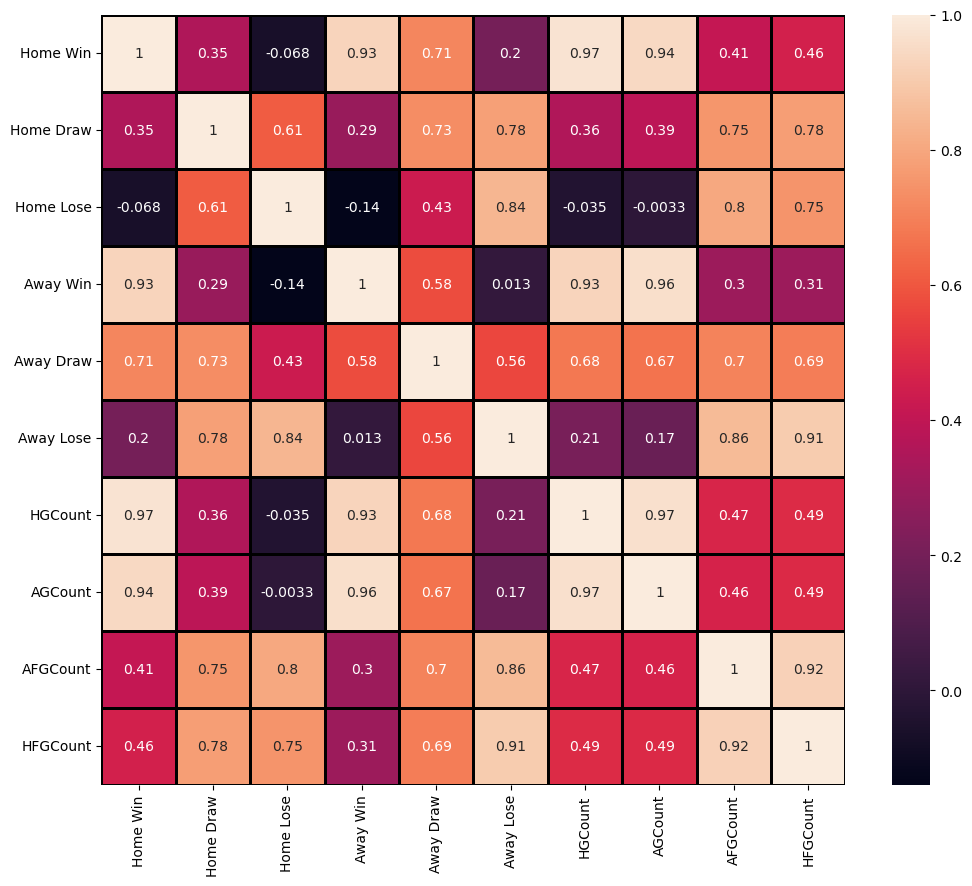

In [9]:
plt.figure(figsize = (12,10))
sns.heatmap(team_data.corr(), linecolor = 'black', linewidths=1, annot = True)

In [10]:
# скомпоновали в таблицу
countMH = match.groupby(['home_team_name'])['match_api_id'].count(). reset_index(name='MH').copy() # кол-водомашних матчей
countMA = match.groupby(['away_team_name'])['match_api_id'].count(). reset_index(name='MA').copy() # кол-гостевых матчей
countM = countMH.merge(countMA, left_on='home_team_name', right_on='away_team_name', how='left')
countM.drop(countM.columns[[2]], axis= 1 , inplace= True)
team_data = team_data.merge(countM, left_on='home_team_name', right_on='home_team_name', how='left')
team_data = team_data.astype({'MH': np.int,'MA': np.int})
team_data["CM"] = team_data[['MH','MA']].sum(axis=1)                                               # общее кол-во матчей
team_data 

,home_team_name,league,Home Win,Home Draw,Home Lose,Away Win,Away Draw,Away Lose,match summary,HGCount,AGCount,AFGCount,HFGCount,MH,MA,CM
0,1. FC Kaiserslautern,Germany 1. Bundesliga,8,11,15,9,7,18,Away Win,37,35,47,58,34,34,68
1,1. FC Kaiserslautern,Germany 1. Bundesliga,8,11,15,9,7,18,Win,37,35,47,58,34,34,68
2,1. FC Kaiserslautern,Germany 1. Bundesliga,8,11,15,9,7,18,Away Win,37,35,47,58,34,34,68
3,1. FC Kaiserslautern,Germany 1. Bundesliga,8,11,15,9,7,18,Win,37,35,47,58,34,34,68
4,1. FC Kaiserslautern,Germany 1. Bundesliga,8,11,15,9,7,18,Away Win,37,35,47,58,34,34,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,Śląsk Wrocław,Poland Ekstraklasa,59,35,26,30,45,45,Draw,176,142,107,180,120,120,240
25975,Śląsk Wrocław,Poland Ekstraklasa,59,35,26,30,45,45,Away Win,176,142,107,180,120,120,240
25976,Śląsk Wrocław,Poland Ekstraklasa,59,35,26,30,45,45,Away Win,176,142,107,180,120,120,240
25977,Śląsk Wrocław,Poland Ekstraklasa,59,35,26,30,45,45,Win,176,142,107,180,120,120,240


In [11]:
# пересчёт всех показателей по каждой команде
winH_table = team_data[['home_team_name','Home Win']].copy()
winH_table['type'] = np.where(winH_table['Home Win']>0, 'Home', 'Home')
winH_table['game_result'] = np.where(winH_table['Home Win']>0, 'Win', 'Win')
winH_table.rename(columns = {'Home Win':'game_result_score'}, inplace = True)
winH_table = winH_table[['home_team_name','type','game_result','game_result_score']]
winA_table = team_data[['home_team_name','Away Win']].copy()
winA_table['type'] = np.where(winA_table['Away Win']>0, 'Away', 'Away')
winA_table['game_result'] = np.where(winA_table['Away Win']>0, 'Win', 'Win')
winA_table.rename(columns = {'Away Win':'game_result_score'}, inplace = True)
winA_table = winA_table[['home_team_name','type','game_result','game_result_score']]
drawH_table = team_data[['home_team_name','Home Draw']].copy()
drawH_table['type'] = np.where(drawH_table['Home Draw']>0, 'Home', 'Home')
drawH_table['game_result'] = np.where(drawH_table['Home Draw']>0, 'Draw', 'Draw')
drawH_table.rename(columns = {'Home Draw':'game_result_score'}, inplace = True)
drawH_table = drawH_table[['home_team_name','type','game_result','game_result_score']]
drawA_table = team_data[['home_team_name','Away Draw']].copy()
drawA_table['type'] = np.where(drawA_table['Away Draw']>0, 'Away', 'Away')
drawA_table['game_result'] = np.where(drawA_table['Away Draw']>0, 'Draw', 'Draw')
drawA_table.rename(columns = {'Away Draw':'game_result_score'}, inplace = True)
drawA_table = drawA_table[['home_team_name','type','game_result','game_result_score']]
loseH_table = team_data[['home_team_name','Home Lose']].copy()
loseH_table['type'] = np.where(loseH_table['Home Lose']>0, 'Home', 'Home')
loseH_table['game_result'] = np.where(loseH_table['Home Lose']>0, 'Lose', 'Lose')
loseH_table.rename(columns = {'Home Lose':'game_result_score'}, inplace = True)
loseH_table = loseH_table[['home_team_name','type','game_result','game_result_score']]
loseA_table = team_data[['home_team_name','Away Lose']].copy()
loseA_table['type'] = np.where(loseA_table['Away Lose']>0, 'Away', 'Away')
loseA_table['game_result'] = np.where(loseA_table['Away Lose']>0, 'Lose', 'Lose')
loseA_table.rename(columns = {'Away Lose':'game_result_score'}, inplace = True)
loseA_table = loseA_table[['home_team_name','type','game_result','game_result_score']]

In [12]:
# приведём собранную статистику к виду который будем использовать
win_stat = winH_table.append(winA_table,sort = False)
draw_stat = drawH_table.append(drawA_table,sort = False)
lose_stat = loseH_table.append(loseA_table,sort = False)
win_stat = win_stat.append(draw_stat,sort = False)
match_stat = lose_stat.append(win_stat,sort = False)
match_stat

,home_team_name,type,game_result,game_result_score
0,1. FC Kaiserslautern,Home,Lose,15
1,1. FC Kaiserslautern,Home,Lose,15
2,1. FC Kaiserslautern,Home,Lose,15
3,1. FC Kaiserslautern,Home,Lose,15
4,1. FC Kaiserslautern,Home,Lose,15
...,...,...,...,...
25974,Śląsk Wrocław,Away,Draw,45
25975,Śląsk Wrocław,Away,Draw,45
25976,Śląsk Wrocław,Away,Draw,45
25977,Śląsk Wrocław,Away,Draw,45


In [13]:
# для дашборда

# считаем исходы матчей дома
Home_match = Match[['id', 'country_id', 'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id',
                        'home_team_goal', 'away_team_goal']]
Home_match['Home/Away'] = 'Home'

def f(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 'Win'
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 'Draw'
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 'Lose'
    return val
Home_match['match_result'] = Home_match.apply (f, axis=1)
Home_match.rename(columns = {'home_team_api_id':'team_api_id','home_team_goal':'team_goal'}, inplace = True)
Home_match = Home_match.drop(Home_match.columns[9], axis= 1)

# считаем исходы матчей в гостях
Away_match = Match[['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal']]
Away_match['Home/Away'] = 'Away'

def f(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 'Lose'
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 'Draw'
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 'Win'
    return val
Away_match['match_result'] = Away_match.apply (f, axis=1)
Away_match.rename(columns = {'away_team_api_id':'team_api_id','away_team_goal':'team_goal'}, inplace = True)
Away_match = Away_match.drop(Away_match.columns[8], axis= 1)

# соединяем таблицы для сбора общей статистики по матчам и дальнейшей визуализации
teams_match_stats=pd.concat([Home_match, Away_match], axis=0)
teams_match_stats=teams_match_stats.sort_values(['date'], ascending = [False])
teams_match_stats = teams_match_stats.merge(league, left_on='country_id', right_on='country_id', how='left')
teams_match_stats = teams_match_stats.merge(Team, left_on='team_api_id', right_on='team_api_id', how='left')
teams_match_stats

,id,country_id,league_id,season,stage,date,match_api_id,team_api_id,team_goal,Home/Away,match_result,country,league,team_long_name
0,25945,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992225,9931,0,Home,Lose,Switzerland,Switzerland Super League,FC Basel
1,25949,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992229,10243,3,Home,Win,Switzerland,Switzerland Super League,FC Zürich
2,25948,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992228,10192,3,Away,Win,Switzerland,Switzerland Super League,BSC Young Boys
3,25949,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992229,9824,1,Away,Lose,Switzerland,Switzerland Super League,FC Vaduz
4,25947,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992227,10179,2,Away,Draw,Switzerland,Switzerland Super League,FC Sion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,24561,24558,24558,2008/2009,1,2008-07-20 00:00:00,486265,10199,1,Home,Lose,Switzerland,Switzerland Super League,FC Luzern
51954,24560,24558,24558,2008/2009,1,2008-07-19 00:00:00,486264,9930,3,Home,Win,Switzerland,Switzerland Super League,FC Aarau
51955,24560,24558,24558,2008/2009,1,2008-07-19 00:00:00,486264,10179,1,Away,Lose,Switzerland,Switzerland Super League,FC Sion
51956,24559,24558,24558,2008/2009,1,2008-07-18 00:00:00,486263,9931,2,Away,Win,Switzerland,Switzerland Super League,FC Basel


In [14]:
# подготовим датасет с атребутами команд

In [15]:
# создаём переменную с интерисующими нас атребутами команды
team_attributes = pd.read_sql_query("""SELECT Team.id,
                                    Team.team_api_id,
                                    team_long_name,
                                    date,
                                    buildUpPlaySpeed,
                                    buildUpPlayDribbling,
                                    buildUpPlayPassing,
                                    chanceCreationPassing,
                                    chanceCreationCrossing,
                                    chanceCreationShooting,
                                    defencePressure,
                                    defenceAggression,
                                    defenceTeamWidth
                                    FROM Team 
                                    JOIN Team_Attributes on Team.team_api_id=Team_Attributes.team_api_id;""",conn)
team_attributes.describe()

,id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,22692.858711,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,15015.159107,13264.869900,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,9547.250000,8457.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,20524.500000,8674.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,35294.000000,9904.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,50204.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [16]:
# выбирем только актуальные данные по дате обновления и оцениваем данные на наличие пропусков и выбросов
team_attributes = team_attributes[team_attributes['date']>'2015-01-01']
team_attributes.drop(team_attributes.columns[[3]], axis= 1 , inplace= True)
team_attributes.isnull().sum()

id                        0
team_api_id               0
team_long_name            0
buildUpPlaySpeed          0
buildUpPlayDribbling      0
buildUpPlayPassing        0
chanceCreationPassing     0
chanceCreationCrossing    0
chanceCreationShooting    0
defencePressure           0
defenceAggression         0
defenceTeamWidth          0
dtype: int64

<AxesSubplot:>

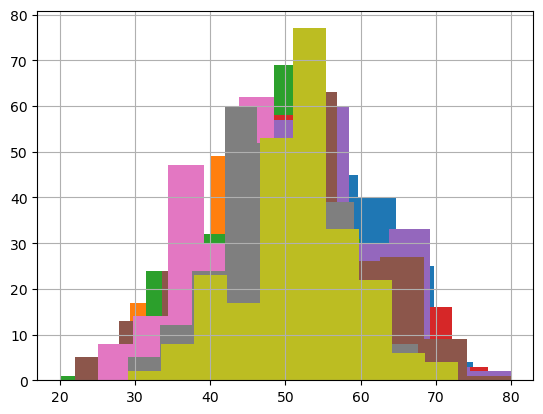

In [17]:
# верхнеуровнево смотрим расределения по каждому атребуту
team_attributes['buildUpPlaySpeed'].hist()
team_attributes['buildUpPlayDribbling'].hist()
team_attributes['buildUpPlayPassing'].hist()
team_attributes['chanceCreationPassing'].hist()
team_attributes['chanceCreationCrossing'].hist()
team_attributes['chanceCreationShooting'].hist()
team_attributes['defencePressure'].hist()
team_attributes['defenceAggression'].hist()
team_attributes['defenceTeamWidth'].hist()

In [18]:
# присваеваем числовое значение для каждой команды по итогам матча:0-проигрыш, 1- ничья, 2 - победа
team_match_corr = Match[['match_api_id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal']]

def f(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 2
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 1
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 0
    return val
team_match_corr['Home_match_result'] = team_match_corr.apply (f, axis=1)


def v(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 1
    elif row['home_team_goal'] < row['away_team_goal']:
        val = 2
    return val
team_match_corr['Away_match_result'] = team_match_corr.apply (v, axis=1)

# групируем сумму балов по командам за все игры по исходам (чем больше баллов - тем больше побед)
home_team_total_result = team_match_corr.groupby('home_team_api_id')['Home_match_result'].sum()
away_team_total_result = team_match_corr.groupby('away_team_api_id')['Away_match_result'].sum()

# рассчитываем общее количество матчей домашних и гостевых
total_home_match = team_match_corr.groupby('home_team_api_id')['match_api_id'].count()
total_away_match = team_match_corr.groupby('away_team_api_id')['match_api_id'].count()

# объеденяем в таблицу результат
team_match_corr = team_match_corr.merge(home_team_total_result, left_on = 'home_team_api_id', right_on = 'home_team_api_id',how = 'left')
team_match_corr = team_match_corr.merge(away_team_total_result, left_on = 'away_team_api_id', right_on = 'away_team_api_id', how = 'left')
team_match_corr = team_match_corr.merge(total_home_match, left_on = 'home_team_api_id', right_on = 'home_team_api_id', how = 'left')
team_match_corr = team_match_corr.merge(total_away_match, left_on = 'away_team_api_id', right_on = 'away_team_api_id', how = 'left')

# переименовываем стольбцы
team_match_corr.rename(columns = {'Home_match_result_x':'Home_match_result','Away_match_result_x':'Away_match_result',
                                  'Home_match_result_y':'home_team_total_result', 'Away_match_result_y':'Away_team_total_result',
                                  'match_api_id_y':'total_home_match', 'match_api_id':'total_away_match'
                                  }, inplace = True)
team_match_corr.rename(columns = {'match_api_id_x':'match_api_id'
                                  }, inplace = True)
team_match_corr

,match_api_id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Home_match_result,Away_match_result,home_team_total_result,Away_team_total_result,total_home_match,total_away_match
0,492473,1,1,2008/2009,1,2008-08-17 00:00:00,9987,9993,1,1,1,1,147,37,106,76
1,492474,1,1,2008/2009,1,2008-08-16 00:00:00,10000,9994,0,0,1,1,122,98,106,106
2,492475,1,1,2008/2009,1,2008-08-16 00:00:00,9984,8635,0,3,0,2,92,142,91,106
3,492476,1,1,2008/2009,1,2008-08-17 00:00:00,9991,9998,5,0,2,0,145,28,109,47
4,492477,1,1,2008/2009,1,2008-08-16 00:00:00,7947,9985,1,3,0,2,14,105,17,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,24558,24558,2015/2016,9,2015-09-22 00:00:00,10190,10191,1,0,2,0,116,85,108,107
25975,1992092,24558,24558,2015/2016,9,2015-09-23 00:00:00,9824,10199,1,2,0,2,41,117,54,143
25976,1992093,24558,24558,2015/2016,9,2015-09-23 00:00:00,9956,10179,2,0,2,0,172,105,143,143
25977,1992094,24558,24558,2015/2016,9,2015-09-22 00:00:00,7896,10243,0,0,1,1,16,147,18,143


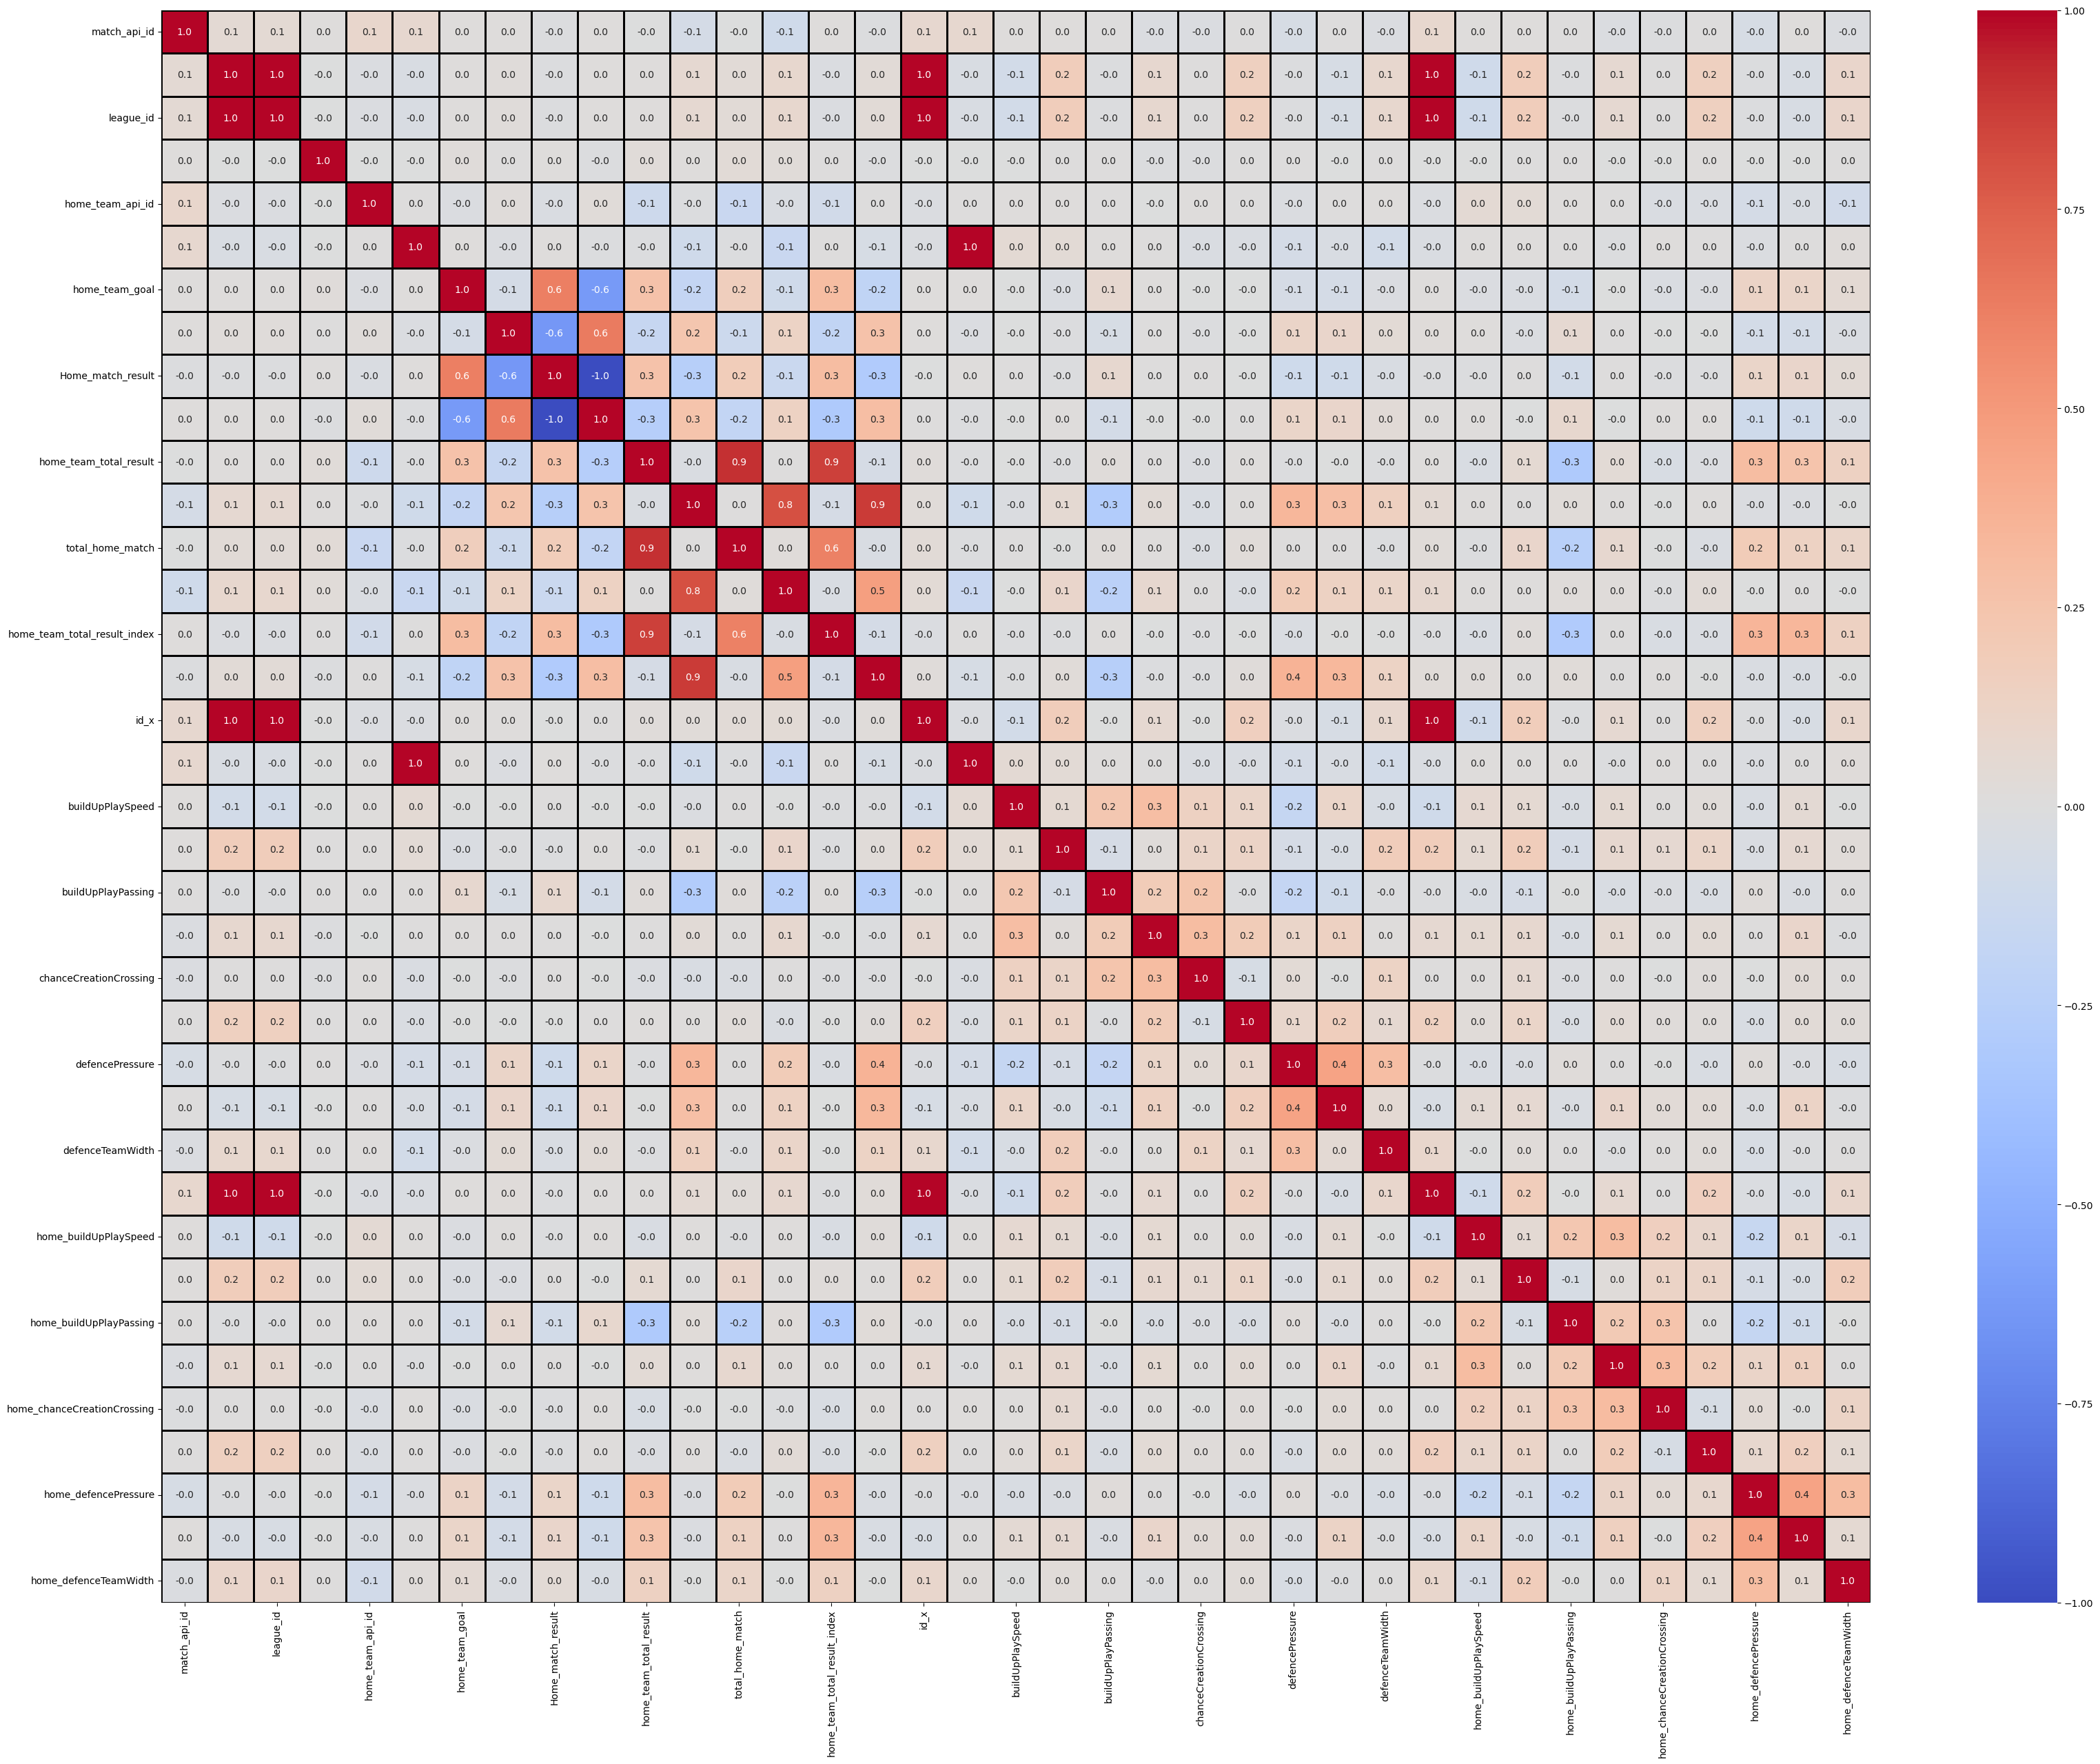

In [19]:
# рассчитываем индекс домашних и гостевых результатов, который является отношением тотал результата к количеству матчей
team_match_corr['home_team_total_result_index']=team_match_corr['home_team_total_result']/team_match_corr['total_home_match']
team_match_corr['away_team_total_result_index']=team_match_corr['Away_team_total_result']/team_match_corr['total_away_match']

# создаем отдельный датасет с характеристиками домашних команд и переименовываем колонки для обозначения этого. колонки и датасет без префикса 'home' будут считать по умолчанию гостевыми
home_team_attributes = team_attributes.rename(columns = {'team_api_id': 'home_team_api_id', 'buildUpPlaySpeed':'home_buildUpPlaySpeed', 'buildUpPlayDribbling':'home_buildUpPlayDribbling',
       'buildUpPlayPassing':'home_buildUpPlayPassing', 'chanceCreationPassing':'home_chanceCreationPassing', 'chanceCreationCrossing':'home_chanceCreationCrossing',
       'chanceCreationShooting':'home_chanceCreationShooting', 'defencePressure':'home_defencePressure', 'defenceAggression':'home_defenceAggression',
       'defenceTeamWidth':'home_defenceTeamWidth'})

# присоединяем данные по характеристикам команд к статистикам матчей
team_match_corr = team_match_corr.merge(team_attributes, left_on='away_team_api_id', right_on='team_api_id', how='left')
team_match_corr = team_match_corr.merge(home_team_attributes, left_on='home_team_api_id', right_on='home_team_api_id', how='left')

# Удаляем все ненужные дубликаты
team_match_corr.dropna(subset='id_x',inplace=True)
team_match_corr.dropna(subset='Home_match_result',inplace=True)
team_match_corr.dropna(subset='Away_match_result',inplace=True)
team_match_corr.dropna(subset='date',inplace=True)

# смотрим корреляцию характеристик команд и результативность матчей
#team_match_corr.corr()
sns.heatmap(team_match_corr.corr() , cmap= 'coolwarm', linecolor = 'black', linewidths=2, annot=True, fmt=".1f")
plt.gcf().set_size_inches(40,30)
plt.show()

In [20]:
# Для домашних и гостевых команд бнаружена зависимость: 0.1 - buildUpPlayDribling, 0.3 - defencePressure, 0.3 - defenceAggrrssion, 0.1 - defenceTeamWidth. 
# Всего 9 характеристик. Составляем формулу: 0х+0.1х+0х+0х+0х+0х+0.3х+0.3х+0.1х = 1 Х = 1.25 
# Следовательно, все параметры с коэффициентом 0.1 умножаются на 1.25, а с коэффициентом 0.3 на 3.75

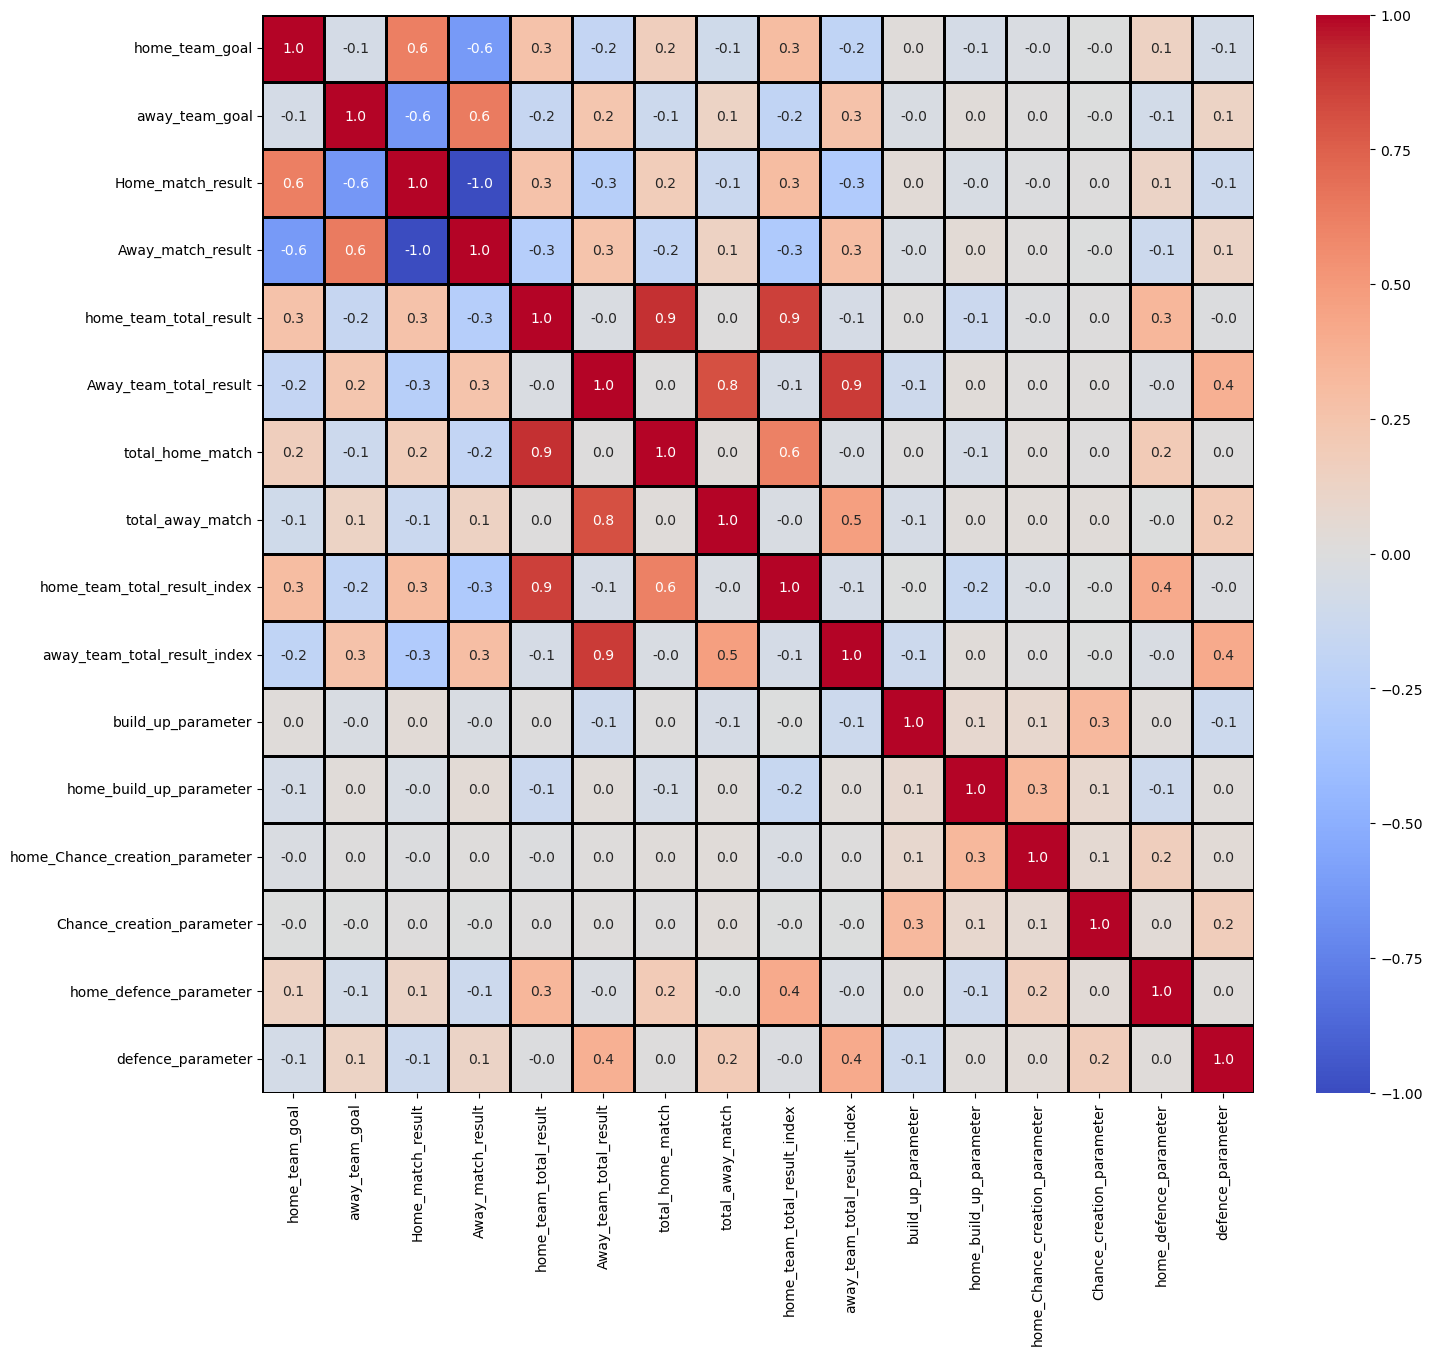

In [21]:
#Находим среднее значение по группам показателей команд для группировки

#Build up - тактика команды в атаке/нападении.
#Build_up_average = (buildUpPlaySpeed + 1.25*buildUpPlayDribbling + buildUpPlayPassing)/3
team_match_corr['build_up_parameter']=(team_match_corr['buildUpPlaySpeed'] + 1.25*team_match_corr['buildUpPlayDribbling'] + team_match_corr['buildUpPlayPassing'] )/3
team_match_corr['home_build_up_parameter']=(team_match_corr['home_buildUpPlaySpeed'] + 1.25*team_match_corr['home_buildUpPlayDribbling'] + team_match_corr['home_buildUpPlayPassing'] )/3

#Chance creation - тактика команды при создании голевых моментов.
#Chance_creation_average = (chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting)/3
team_match_corr['home_Chance_creation_parameter']=(team_match_corr['home_chanceCreationPassing'] + team_match_corr['home_chanceCreationCrossing'] + team_match_corr['home_chanceCreationShooting'] )/3
team_match_corr['Chance_creation_parameter']=(team_match_corr['chanceCreationPassing'] + team_match_corr['chanceCreationCrossing'] + team_match_corr['chanceCreationShooting'] )/3

#Defence - тактика команды в обороне/защите.
#Defence_average = (3.75*defencePressure+3.75*defenceAggression+1.25*defenceTeamWidth)/3
team_match_corr['home_defence_parameter']=(3.75*team_match_corr['home_defencePressure'] + 3.75*team_match_corr['home_defenceAggression'] + 1.25*team_match_corr['home_defenceTeamWidth'] )/3
team_match_corr['defence_parameter']=(3.75*team_match_corr['defencePressure'] + 3.75*team_match_corr['defenceAggression'] + 1.25*team_match_corr['defenceTeamWidth'] )/3

# удаляем лишние столбцы и смотрим снова корреляцию, как мы видим, она увеличилась с учетом новых параметров
team_match_corr_dropped = team_match_corr.drop(team_match_corr.columns[
    [0,1,2,3,4,5,6,7,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
     38,39,40]], axis= 1)

sns.heatmap(team_match_corr_dropped.corr() , cmap= 'coolwarm', linecolor = 'black', linewidths=2, annot=True, fmt=".1f")
plt.gcf().set_size_inches(16,14)
plt.show()

In [22]:
# добавляем к нашему предобработанному файлу team attributes усредненные параметры, дропаем лишнее и скачиваем файл для дашборда
team_attributes['build_up_parameter']=(team_attributes['buildUpPlaySpeed'] + 1.25*team_attributes['buildUpPlayDribbling'] + team_attributes['buildUpPlayPassing'] )/3
team_attributes['Chance_creation_parameter']=(1.25*team_attributes['chanceCreationPassing'] + 1.25*team_attributes['chanceCreationCrossing'] + 1.25*team_attributes['chanceCreationShooting'] )/3
team_attributes['defence_parameter']=(1.25*2*team_attributes['defencePressure'] + 1.25*team_attributes['defenceAggression'] + 1.25*team_attributes['defenceTeamWidth'] )/3

team_attributes['sum_weight']= (team_attributes['build_up_parameter'] + team_attributes['Chance_creation_parameter'] + 2.5*team_attributes['defence_parameter'])/3

team_attributes=team_attributes.drop(team_attributes.columns[[3,4,5,6,7,8,9,10,11]], axis= 1)
team_attributes

,id,team_api_id,team_long_name,build_up_parameter,Chance_creation_parameter,defence_parameter,sum_weight
2,49119,9930,FC Aarau,50.750000,75.416667,80.000000,108.722222
8,39393,8485,Aberdeen,64.000000,77.500000,85.833333,118.694444
14,11817,8576,AC Ajaccio,60.750000,57.500000,73.333333,100.527778
20,20523,8564,Milan,62.500000,71.250000,92.500000,121.666667
26,35292,10215,Académica de Coimbra,54.416667,69.166667,73.750000,102.652778
...,...,...,...,...,...,...,...
1425,4225,8602,Wolverhampton Wanderers,48.333333,62.500000,82.083333,105.347222
1438,49117,10192,BSC Young Boys,62.000000,62.916667,71.666667,101.361111
1449,43803,8394,Real Zaragoza,55.666667,68.750000,78.333333,106.750000
1451,33855,8027,Zawisza Bydgoszcz,52.583333,61.250000,77.916667,102.875000


In [23]:
# подготовим датасет с атребутами игроков

In [24]:
player_attributes = Player_Attributes.copy()
player_attributes.describe()

# переводим тип столбца 'Date' со строчки в дату
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

# отделяем только самые актуальные данные/характеристики по каждому игроку
relevant_date = player_attributes.groupby('player_api_id')['date'].max()
relevant_date   

player_api_id
2625     2015-01-16
2752     2015-10-16
2768     2016-03-17
2770     2013-07-05
2790     2010-08-30
            ...    
744907   2016-06-09
746419   2016-05-12
748432   2016-05-12
750435   2016-04-14
750584   2016-05-19
Name: date, Length: 11060, dtype: datetime64[ns]

In [25]:
# создаем функцию, которая будет устанавливать соответствует ли строчка самой обновленной дате
def reveldate(row):
    if row['date_x'] == row['date_y']:
        val = 'True'
    else: 
        val = 'False'
    return val

# присоединяем столбец с самой обновленной датой по каждому ID
player_attributes = player_attributes.merge(relevant_date, left_on = 'player_api_id', right_on = 'player_api_id', how = 'left')
player_attributes['Relevant_Date'] = player_attributes.apply(reveldate, axis=1)

#отделяем данные/характеристики по каждому игроку только с актуальной датой
player_attributes = player_attributes.loc[player_attributes['Relevant_Date'] == 'True']
player_attributes = player_attributes[player_attributes['date_x']>'2014-01-01']

player_attributes.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,8647.000000,8647.000000,8647.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,...,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000
mean,92139.251185,177612.592922,180447.870360,68.776634,71.598149,54.507577,48.769925,56.960208,62.470098,48.110584,...,56.399653,53.222903,47.482591,51.086755,48.691035,15.756507,15.417235,15.219549,15.550029,15.844997
std,53269.468224,48338.534997,169928.118151,6.275818,6.222078,17.734646,19.107950,16.809080,13.862523,18.095914,...,14.584521,15.872618,21.848111,22.014085,21.949739,17.268769,16.208341,15.722501,16.658191,17.676139
min,1.000000,2.000000,2625.000000,47.000000,49.000000,7.000000,5.000000,8.000000,11.000000,5.000000,...,11.000000,9.000000,3.000000,6.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45903.000000,165362.000000,38738.500000,65.000000,67.000000,45.000000,33.000000,50.000000,58.000000,34.000000,...,47.000000,43.000000,25.000000,29.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,92451.000000,189885.000000,131980.000000,69.000000,71.000000,59.000000,52.000000,60.000000,65.000000,51.000000,...,59.000000,55.000000,53.000000,59.000000,55.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,138586.000000,207532.000000,264087.000000,73.000000,76.000000,67.000000,65.000000,68.000000,71.000000,63.000000,...,67.000000,65.000000,67.000000,70.000000,68.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,183938.000000,234141.000000,750584.000000,94.000000,94.000000,92.000000,95.000000,95.000000,93.000000,92.000000,...,94.000000,96.000000,90.000000,91.000000,95.000000,88.000000,87.000000,91.000000,90.000000,90.000000


In [27]:
# проверяем на наличие дубликатов по ID и дате, так как один и тот же игрок в один и тот же день не может иметь разный рейтинг
player_attributes[player_attributes.duplicated(['player_fifa_api_id', 'player_api_id','date_x'])]

# удаляем эти дублткаты
player_attributes.drop_duplicates(subset=['player_fifa_api_id', 'player_api_id','date_x'], inplace=True)
player_attributes.isnull().sum()

id                     0
player_fifa_api_id     0
player_api_id          0
date_x                 0
overall_rating         2
potential              2
preferred_foot         2
attacking_work_rate    2
defensive_work_rate    2
crossing               2
finishing              2
heading_accuracy       2
short_passing          2
volleys                2
dribbling              2
curve                  2
free_kick_accuracy     2
long_passing           2
ball_control           2
acceleration           2
sprint_speed           2
agility                2
reactions              2
balance                2
shot_power             2
jumping                2
stamina                2
strength               2
long_shots             2
aggression             2
interceptions          2
positioning            2
vision                 2
penalties              2
marking                2
standing_tackle        2
sliding_tackle         2
gk_diving              2
gk_handling            2
gk_kicking             2


In [28]:
# один из способов заполнения пробелов - это замена пустых значений на средним
# заполняем пустые значения на среднее арифметическое по игроку в каждой характеристике
player_attributes['overall_rating'].fillna(player_attributes['overall_rating'].mean(), inplace=True)
player_attributes['potential'].fillna(player_attributes['potential'].mean(), inplace=True)
player_attributes['crossing'].fillna(player_attributes['crossing'].mean(), inplace=True)
player_attributes['finishing'].fillna(player_attributes['finishing'].mean(), inplace=True)
player_attributes['heading_accuracy'].fillna(player_attributes['heading_accuracy'].mean(), inplace=True)
player_attributes['short_passing'].fillna(player_attributes['short_passing'].mean(), inplace=True)
player_attributes['volleys'].fillna(player_attributes['volleys'].mean(), inplace=True)
player_attributes['dribbling'].fillna(player_attributes['dribbling'].mean(), inplace=True)
player_attributes['curve'].fillna(player_attributes['curve'].mean(), inplace=True)
player_attributes['free_kick_accuracy'].fillna(player_attributes['free_kick_accuracy'].mean(), inplace=True)
player_attributes['long_passing'].fillna(player_attributes['long_passing'].mean(), inplace=True)
player_attributes['ball_control'].fillna(player_attributes['ball_control'].mean(), inplace=True)
player_attributes['acceleration'].fillna(player_attributes['acceleration'].mean(), inplace=True)
player_attributes['sprint_speed'].fillna(player_attributes['sprint_speed'].mean(), inplace=True)
player_attributes['agility'].fillna(player_attributes['agility'].mean(), inplace=True)
player_attributes['reactions'].fillna(player_attributes['reactions'].mean(), inplace=True)
player_attributes['balance'].fillna(player_attributes['balance'].mean(), inplace=True)
player_attributes['shot_power'].fillna(player_attributes['shot_power'].mean(), inplace=True)
player_attributes['jumping'].fillna(player_attributes['jumping'].mean(), inplace=True)
player_attributes['stamina'].fillna(player_attributes['stamina'].mean(), inplace=True)
player_attributes['strength'].fillna(player_attributes['strength'].mean(), inplace=True)
player_attributes['long_shots'].fillna(player_attributes['long_shots'].mean(), inplace=True)
player_attributes['aggression'].fillna(player_attributes['aggression'].mean(), inplace=True)
player_attributes['interceptions'].fillna(player_attributes['interceptions'].mean(), inplace=True)
player_attributes['positioning'].fillna(player_attributes['positioning'].mean(), inplace=True)
player_attributes['vision'].fillna(player_attributes['vision'].mean(), inplace=True)
player_attributes['penalties'].fillna(player_attributes['penalties'].mean(), inplace=True)
player_attributes['marking'].fillna(player_attributes['marking'].mean(), inplace=True)
player_attributes['standing_tackle'].fillna(player_attributes['standing_tackle'].mean(), inplace=True)
player_attributes['sliding_tackle'].fillna(player_attributes['sliding_tackle'].mean(), inplace=True)
player_attributes['gk_diving'].fillna(player_attributes['gk_diving'].mean(), inplace=True)
player_attributes['gk_handling'].fillna(player_attributes['gk_handling'].mean(), inplace=True)
player_attributes['gk_kicking'].fillna(player_attributes['gk_kicking'].mean(), inplace=True)
player_attributes['gk_positioning'].fillna(player_attributes['gk_positioning'].mean(), inplace=True)
player_attributes['gk_reflexes'].fillna(player_attributes['gk_reflexes'].mean(), inplace=True)
player_attributes.drop(player_attributes.columns[[1,6,7,8,42,43]], axis= 1 , inplace= True)
player_attributes.isnull().sum()

id                    0
player_api_id         0
date_x                0
overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
dtype: int64

In [29]:
# добавим имена игроков
player = Player.copy()
player.drop(player.columns[[0,3,4,5,6]], axis= 1 , inplace= True)
player_attributes = player_attributes.merge(player, left_on = 'player_api_id', right_on = 'player_api_id', how = 'left')
#player_attributes

In [30]:
# собирём данные по матчам и игрокам в каждой команде
team_player = Match[['date','match_api_id', 'home_team_api_id', 'away_team_api_id','home_player_1', 'home_player_2','home_player_3', 'home_player_4', 'home_player_5', 'home_player_6','home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']]
team_player['date'] = pd.to_datetime(team_player['date'])
team_player=team_player.dropna()
#team_player.describe()

In [31]:
# разделим игроков по командам
home_1=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_1']].rename(columns = {'home_player_1':'player','home_team_api_id':'team_api_id'})
home_2=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_2']].rename(columns = {'home_player_2':'player','home_team_api_id':'team_api_id'})
home_3=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_3']].rename(columns = {'home_player_3':'player','home_team_api_id':'team_api_id'})
home_4=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_4']].rename(columns = {'home_player_4':'player','home_team_api_id':'team_api_id'})
home_5=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_5']].rename(columns = {'home_player_5':'player','home_team_api_id':'team_api_id'})
home_6=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_6']].rename(columns = {'home_player_6':'player','home_team_api_id':'team_api_id'})
home_7=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_7']].rename(columns = {'home_player_7':'player','home_team_api_id':'team_api_id'})
home_8=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_8']].rename(columns = {'home_player_8':'player','home_team_api_id':'team_api_id'})
home_9=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_9']].rename(columns = {'home_player_9':'player','home_team_api_id':'team_api_id'})
home_10=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_10']].rename(columns = {'home_player_10':'player','home_team_api_id':'team_api_id'})
home_11=team_player[['date', 'match_api_id', 'home_team_api_id', 'home_player_11']].rename(columns = {'home_player_11':'player','home_team_api_id':'team_api_id'})
away_1=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_1']].rename(columns = {'away_player_1':'player','away_team_api_id':'team_api_id'})
away_2=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_2']].rename(columns = {'away_player_2':'player','away_team_api_id':'team_api_id'})
away_3=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_3']].rename(columns = {'away_player_3':'player','away_team_api_id':'team_api_id'})
away_4=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_4']].rename(columns = {'away_player_4':'player','away_team_api_id':'team_api_id'})
away_5=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_5']].rename(columns = {'away_player_5':'player','away_team_api_id':'team_api_id'})
away_6=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_6']].rename(columns = {'away_player_6':'player','away_team_api_id':'team_api_id'})
away_7=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_7']].rename(columns = {'away_player_7':'player','away_team_api_id':'team_api_id'})
away_8=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_8']].rename(columns = {'away_player_8':'player','away_team_api_id':'team_api_id'})
away_9=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_9']].rename(columns = {'away_player_9':'player','away_team_api_id':'team_api_id'})
away_10=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_10']].rename(columns = {'away_player_10':'player','away_team_api_id':'team_api_id'})
away_11=team_player[['date', 'match_api_id', 'away_team_api_id', 'away_player_11']].rename(columns = {'away_player_11':'player','away_team_api_id':'team_api_id'})
players_in_team = pd.concat([home_1,home_2,home_3,home_4,home_5,home_6,home_7,home_8,home_9,home_10,home_11,away_1,away_2,away_3,away_4,away_5,away_6,away_7,away_8,away_9,away_10,away_11], axis=0)
#players_in_team

In [32]:
players_in_team['player'] = players_in_team['player'].astype(int)
players_in_team = players_in_team.sort_values(['date'], ascending = [False])
players_t = players_in_team.drop_duplicates(subset='player',  keep='first')
players_in_team = player_attributes.merge(players_t, left_on='player_api_id', right_on='player', how='left')
#players_in_team

In [33]:
# упорядочим данные и оставим только нужное для визуализации
players_in_team = players_in_team.merge(Team, left_on = 'team_api_id', right_on = 'team_api_id', how = 'left')
players_in_team = players_in_team[players_in_team.team_api_id > 0]
players_in_team['team_api_id'] = players_in_team['team_api_id'].astype(int)
players_in_team = players_in_team[['id', 'player_name', 'player_api_id', 'team_long_name', 'team_api_id', 'overall_rating']]
players_in_team

,id,player_name,player_api_id,team_long_name,team_api_id,overall_rating
0,1,Aaron Appindangoye,505942,Boavista FC,8613,67.0
1,6,Aaron Cresswell,155782,West Ham United,8654,74.0
2,39,Aaron Doran,162549,Inverness Caledonian Thistle,8066,65.0
3,65,Aaron Galindo,30572,Eintracht Frankfurt,9810,69.0
4,88,Aaron Hughes,23780,Fulham,9879,70.0
...,...,...,...,...,...,...
8642,183873,Zoran Tosic,99031,1. FC Köln,8722,79.0
8643,183896,Zouhaier Dhaouadhi,192132,Évian Thonon Gaillard FC,4087,64.0
8644,183904,Zouhair Feddal,282473,Levante UD,8581,75.0
8645,183925,Zoumana Camara,26357,Paris Saint-Germain,9847,73.0


In [34]:
# предсказательная модель

In [35]:
# заново соберём датасет
matches = Match[Match.columns[:11]]
matches = pd.merge(left=matches, right=Team, how='left', left_on='home_team_api_id', right_on='team_api_id')
matches = matches.drop(['country_id','league_id', 'home_team_api_id', 'team_api_id'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'home_team'}, inplace=True)
matches = pd.merge(left=matches, right=Team, how='left', left_on='away_team_api_id', right_on='team_api_id')
matches = matches.drop(['id', 'away_team_api_id','team_api_id'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'away_team', 'match_api_id':'match_id'}, inplace=True)
matches = matches[['match_id','season','stage','date','home_team_goal','away_team_goal','home_team','away_team']]
matches

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team
0,492473,2008/2009,1,2008-08-17 00:00:00,1,1,KRC Genk,Beerschot AC
1,492474,2008/2009,1,2008-08-16 00:00:00,0,0,SV Zulte-Waregem,Sporting Lokeren
2,492475,2008/2009,1,2008-08-16 00:00:00,0,3,KSV Cercle Brugge,RSC Anderlecht
3,492476,2008/2009,1,2008-08-17 00:00:00,5,0,KAA Gent,RAEC Mons
4,492477,2008/2009,1,2008-08-16 00:00:00,1,3,FCV Dender EH,Standard de Liège
...,...,...,...,...,...,...,...,...
25974,1992091,2015/2016,9,2015-09-22 00:00:00,1,0,FC St. Gallen,FC Thun
25975,1992092,2015/2016,9,2015-09-23 00:00:00,1,2,FC Vaduz,FC Luzern
25976,1992093,2015/2016,9,2015-09-23 00:00:00,2,0,Grasshopper Club Zürich,FC Sion
25977,1992094,2015/2016,9,2015-09-22 00:00:00,0,0,Lugano,FC Zürich


In [36]:
# приведём победы, поражения и ничьи в бинарный вид
def determine_home_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 'win'
    elif match['home_team_goal'] < match['away_team_goal']:
        return 'loss'
    else:
        return 'draw'

def determine_away_result(match):
    if match['away_team_goal'] > match['home_team_goal']:
        return 'win'
    elif match['away_team_goal'] < match['home_team_goal']:
        return 'loss'
    else:
        return 'draw'

matches['home_team_result'] = matches.apply(determine_home_result, axis=1)
matches['away_team_result'] = matches.apply(determine_away_result, axis=1)

def determine_result(match_list):
    match_list['home_win'] = np.where(match_list['home_team_goal'] > match_list['away_team_goal'], 1, 0)
    match_list['home_draw'] = np.where(match_list['home_team_goal'] == match_list['away_team_goal'], 1, 0)
    match_list['home_lose'] = np.where(match_list['home_team_goal'] < match_list['away_team_goal'], 1, 0)
    match_list['away_win'] = np.where(match_list['home_team_goal'] < match_list['away_team_goal'], 1, 0)
    match_list['away_draw'] = np.where(match_list['home_team_goal'] == match_list['away_team_goal'], 1, 0)
    match_list['away_lose'] = np.where(match_list['home_team_goal'] > match_list['away_team_goal'], 1, 0)

determine_result(matches)
matches

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,home_win,home_draw,home_lose,away_win,away_draw,away_lose
0,492473,2008/2009,1,2008-08-17 00:00:00,1,1,KRC Genk,Beerschot AC,draw,draw,0,1,0,0,1,0
1,492474,2008/2009,1,2008-08-16 00:00:00,0,0,SV Zulte-Waregem,Sporting Lokeren,draw,draw,0,1,0,0,1,0
2,492475,2008/2009,1,2008-08-16 00:00:00,0,3,KSV Cercle Brugge,RSC Anderlecht,loss,win,0,0,1,1,0,0
3,492476,2008/2009,1,2008-08-17 00:00:00,5,0,KAA Gent,RAEC Mons,win,loss,1,0,0,0,0,1
4,492477,2008/2009,1,2008-08-16 00:00:00,1,3,FCV Dender EH,Standard de Liège,loss,win,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,2015/2016,9,2015-09-22 00:00:00,1,0,FC St. Gallen,FC Thun,win,loss,1,0,0,0,0,1
25975,1992092,2015/2016,9,2015-09-23 00:00:00,1,2,FC Vaduz,FC Luzern,loss,win,0,0,1,1,0,0
25976,1992093,2015/2016,9,2015-09-23 00:00:00,2,0,Grasshopper Club Zürich,FC Sion,win,loss,1,0,0,0,0,1
25977,1992094,2015/2016,9,2015-09-22 00:00:00,0,0,Lugano,FC Zürich,draw,draw,0,1,0,0,1,0


In [37]:
# агрегируем результат и проводим вычисления вероятности успеха команд
team_results_agg = team_data[team_data.columns[:8]].copy()
team_results_agg['home_win_pct'] = team_data['Home Win'] / (team_data['Home Win'] +
                                                                   team_data['Home Draw'] +
                                                                   team_data['Home Lose'])
team_results_agg['home_draw_pct'] = team_data['Home Draw'] / (team_data['Home Win'] +
                                                                   team_data['Home Draw'] +
                                                                   team_data['Home Lose'])
team_results_agg['home_lose_pct'] = team_data['Home Lose'] / (team_data['Home Win'] +
                                                                   team_data['Home Draw'] +
                                                                   team_data['Home Lose'])

team_results_agg['away_win_pct'] = team_data['Away Win'] / (team_data['Away Win'] +
                                                                   team_data['Away Draw'] +
                                                                   team_data['Away Lose'])
team_results_agg['away_draw_pct'] = team_data['Away Draw'] / (team_data['Away Win'] +
                                                                   team_data['Away Draw'] +
                                                                   team_data['Away Lose'])
team_results_agg['away_lose_pct'] = team_data['Away Lose'] / (team_data['Away Win'] +
                                                                   team_data['Away Draw'] +
                                                                   team_data['Away Lose'])

team_results_agg.rename(columns={'home_team_name':'team'}, inplace=True)
team_results_agg.drop_duplicates(inplace = True)
#team_results_agg

In [38]:
home_results = team_results_agg[['team', 'league', 'home_win_pct', 'home_draw_pct', 'home_lose_pct']]
home_results.columns=['team', 'league', 'win', 'draw', 'lose']
#home_results

away_results = team_results_agg[['team', 'league', 'away_win_pct', 'away_draw_pct', 'away_lose_pct']]
away_results.columns=['team', 'league', 'win', 'draw', 'lose']
#away_results

predict_results = matches[['home_team', 'away_team']]
# добавим W/D/L для домашней команды
predict_results = pd.merge(left=predict_results, right=home_results, how='left', left_on='home_team', right_on='team')
predict_results = predict_results.drop(['team'], axis=1)
#matches.rename(columns={'id_x':'match_id', 'team_long_name':'home_team'}, inplace=True)
predict_results

# добавим W/D/L для гостевой команды
predict_results = pd.merge(left=predict_results, right=away_results, how='left', left_on='away_team', right_on='team')
predict_results = predict_results.drop(['team'], axis=1)

# посчитаем среднее исходя из того что победа домашней команды - это поражение гостевой
predict_results['win'] = (predict_results['win_x'] + predict_results['lose_y']) / 2
predict_results['draw'] = (predict_results['draw_x'] + predict_results['draw_y']) / 2
predict_results['lose'] = (predict_results['lose_x'] + predict_results['win_y']) / 2
predict_results = predict_results.drop(['win_x', 'draw_x', 'lose_x', 'win_y', 'draw_y', 'lose_y', 'league_x'], axis=1)

def predict_home_result(match):
    if (match['win'] >= match['draw']) & (match['win'] >= match['lose']):
        return 'win' # отдаём предпочтение домашней победе, если вероятность равна
    elif (match['lose'] > match['win']) & (match['lose'] > match['draw']):
        return 'lose'
    else:
        return 'draw'

predict_results['home_team_result'] = predict_results.apply(predict_home_result, axis=1)
#predict_results

# добавим практический результат
test_matches = matches.copy()
test_matches['home_team_result'] = test_matches.apply(determine_home_result, axis=1)
predict_results['actual_result'] = test_matches['home_team_result']
predict_results.rename(columns={'win':'home win','lose':'away win','league_y':'league'}, inplace=True)
predict_results

,home_team,away_team,league,home win,draw,away win,home_team_result,actual_result
0,KRC Genk,Beerschot AC,Belgium Jupiler League,0.610104,0.229767,0.160129,win,draw
1,SV Zulte-Waregem,Sporting Lokeren,Belgium Jupiler League,0.405660,0.301887,0.292453,win,draw
2,KSV Cercle Brugge,RSC Anderlecht,Belgium Jupiler League,0.307848,0.219988,0.472165,lose,loss
3,KAA Gent,RAEC Mons,Belgium Jupiler League,0.586863,0.193539,0.219598,win,win
4,FCV Dender EH,Standard de Liège,Belgium Jupiler League,0.340455,0.235572,0.423973,lose,loss
...,...,...,...,...,...,...,...,...
25974,FC St. Gallen,FC Thun,Switzerland Super League,0.428046,0.283749,0.288205,win,win
25975,FC Vaduz,FC Luzern,Switzerland Super League,0.323362,0.323815,0.352823,lose,loss
25976,Grasshopper Club Zürich,FC Sion,Switzerland Super League,0.500000,0.234266,0.265734,win,win
25977,Lugano,FC Zürich,Switzerland Super League,0.355478,0.219503,0.425019,lose,draw


In [39]:
# выясним какой результат прогнозируется лучше
predict_correct = predict_results[['home_team_result', 'actual_result']][predict_results['actual_result'] == predict_results['home_team_result']]
predict_analysis = predict_correct.groupby('home_team_result').count()
predict_total = predict_results[['home_team_result', 'actual_result']]
predict_analysis['Total'] = predict_total.groupby('home_team_result').count()
predict_analysis['% Correct'] = predict_analysis['actual_result'] / predict_analysis['Total']

predict_analysis

,actual_result,Total,% Correct
home_team_result,,,
draw,85,186,0.456989
win,11089,21679,0.511509


In [40]:
# Сохранение результатов для визуализации в дашборде
#teams_match_stats.to_csv (r'C:\Users\Rustam\Downloads\match_stat_data.csv', index= False )
#team_attributes.to_csv (r'C:\Users\Rustam\Downloads\team_attributes_data.csv', index= False )
#players_in_team.to_csv (r'C:\Users\Rustam\Downloads\players_in_team_data.csv', index= False )
#predict_results.to_csv (r'C:\Users\Rustam\Downloads\predict_results_data.csv', index= False )

In [41]:
# собираем данные для обучения модели
full_matches = matches.copy()
unique_seasons = pd.Series(matches['season'].unique())
regress_seasons = pd.Series(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015'])
regress_matches = full_matches.loc[full_matches['season'].isin(regress_seasons)]

remaining_seasons = unique_seasons[~unique_seasons.isin(regress_seasons)]

exclude_seasons = pd.Series(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015'])

include_seasons = unique_seasons[~unique_seasons.isin(exclude_seasons)]
full_matches = full_matches.loc[full_matches['season'].isin(include_seasons)]

full_matches

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,home_win,home_draw,home_lose,away_win,away_draw,away_lose
1488,1979832,2015/2016,1,2015-07-24 00:00:00,2,1,Sint-Truidense VV,Club Brugge KV,win,loss,1,0,0,0,0,1
1489,1979833,2015/2016,1,2015-07-25 00:00:00,2,1,KV Kortrijk,Standard de Liège,win,loss,1,0,0,0,0,1
1490,1979834,2015/2016,1,2015-07-25 00:00:00,3,1,KRC Genk,Oud-Heverlee Leuven,win,loss,1,0,0,0,0,1
1491,1979835,2015/2016,1,2015-07-25 00:00:00,3,1,KV Oostende,KV Mechelen,win,loss,1,0,0,0,0,1
1492,1979836,2015/2016,1,2015-07-25 00:00:00,3,1,SV Zulte-Waregem,Sporting Lokeren,win,loss,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,2015/2016,9,2015-09-22 00:00:00,1,0,FC St. Gallen,FC Thun,win,loss,1,0,0,0,0,1
25975,1992092,2015/2016,9,2015-09-23 00:00:00,1,2,FC Vaduz,FC Luzern,loss,win,0,0,1,1,0,0
25976,1992093,2015/2016,9,2015-09-23 00:00:00,2,0,Grasshopper Club Zürich,FC Sion,win,loss,1,0,0,0,0,1
25977,1992094,2015/2016,9,2015-09-22 00:00:00,0,0,Lugano,FC Zürich,draw,draw,0,1,0,0,1,0


In [42]:
# создаём датафрейм данных со строкой для команды и итоговыми результатами

def aggregate_team_results(match_list):
    
    team_res_agg = match_list.groupby(['home_team']).agg({'home_win':sum,
                                                           'home_draw':sum,
                                                           'home_lose':sum
                                                          })

    team_res_agg = pd.concat([team_res_agg,
                                  match_list.groupby(['away_team']).agg({'away_win':sum,
                                                                      'away_draw':sum,
                                                                      'away_lose':sum
                                                                     })
                                 ], axis=1).reset_index()

    team_res_agg.rename(columns={'index':'team'}, inplace=True)
    return team_res_agg

regr_model_seasons = pd.DataFrame(regress_seasons, columns=['season'])
regr_model_remain_seasons = pd.DataFrame(remaining_seasons, columns=['season'])
regr_model_remain_seasons = regr_model_remain_seasons.reset_index(drop=True)
regr_model_team_results_agg = pd.DataFrame()

for i, row in regr_model_remain_seasons.iterrows():
    
    regr_model_matches = matches.loc[matches['season'].isin(regr_model_seasons['season'])]
    regr_model_this_seas_team_results_agg = aggregate_team_results(regr_model_matches)
    regr_model_this_seas_team_results_agg = regr_model_this_seas_team_results_agg.reset_index(drop=True)

    number_seasons = len(regr_model_seasons)
    regr_model_team_names = pd.DataFrame(regr_model_this_seas_team_results_agg['team'])
    regr_model_this_seas_team_results_agg = (regr_model_this_seas_team_results_agg.iloc[:,1:7].applymap(lambda x: x/number_seasons))
    regr_model_this_seas_team_results_agg = pd.concat([regr_model_team_names, regr_model_this_seas_team_results_agg], axis=1)
    regr_model_this_seas_team_results_agg['season'] = regr_model_remain_seasons['season'].loc[i]
    
    regr_model_team_results_agg = pd.concat([regr_model_team_results_agg, regr_model_this_seas_team_results_agg])
    regr_model_team_results_agg = regr_model_team_results_agg.reset_index(drop=True)
    
    regr_model_seasons = regr_model_seasons.append(regr_model_remain_seasons.loc[i])

regr_model_home_team_results_agg = regr_model_team_results_agg[['season', 'team', 'home_win', 'home_draw', 'home_lose']]
regr_model_home_team_results_agg.columns=['r_season', 'r_team', 'r_h_win', 'r_h_draw', 'r_h_lose']

regr_model_away_team_results_agg = regr_model_team_results_agg[['season', 'team', 'away_win', 'away_draw', 'away_lose']]
regr_model_away_team_results_agg.columns=['r_season', 'r_team', 'r_a_win', 'r_a_draw', 'r_a_lose']

In [43]:
# регресисия для выездных матчей
regr_features = full_matches.copy()

unique_teams = pd.DataFrame(full_matches.home_team.unique(), columns=['team'])

regr_home_features = pd.merge(left=regr_features, right=regr_model_home_team_results_agg, how='left', left_on=['home_team', 'season'], right_on=['r_team', 'r_season'])
regr_home_features.sort_values(by=['home_team', 'date'], inplace=True)
regr_home_features.reset_index(drop=True, inplace=True)

previous_season = 'blank'
previous_team = 'blank'

for i, row in regr_home_features.iterrows():
    if (row['season'] != previous_season) or (row['home_team'] != previous_team):
        # New season or team
        previous_season = row['season']
        previous_team = row['home_team']
    else:
        # Wins
        if regr_home_features.loc[i-1, 'home_win'] == 1:
            regr_home_features.loc[i, 'r_h_win'] = regr_home_features.loc[i-1, 'r_h_win'] - 1
        else:
            regr_home_features.loc[i, 'r_h_win'] = regr_home_features.loc[i-1, 'r_h_win']
        # Draws
        if regr_home_features.loc[i-1, 'home_draw'] == 1:
            regr_home_features.loc[i, 'r_h_draw'] = regr_home_features.loc[i-1, 'r_h_draw'] - 1
        else:
            regr_home_features.loc[i, 'r_h_draw'] = regr_home_features.loc[i-1, 'r_h_draw']
        # Losses
        if regr_home_features.loc[i-1, 'home_lose'] == 1:
            regr_home_features.loc[i, 'r_h_lose'] = regr_home_features.loc[i-1, 'r_h_lose'] - 1
        else:
            regr_home_features.loc[i, 'r_h_lose'] = regr_home_features.loc[i-1, 'r_h_lose']

def replace_negatives(value):
    if value < 0:
        return 0
    else:
        return value
    
    
regr_home_features['r_h_win'] = regr_home_features['r_h_win'].apply(replace_negatives) 
regr_home_features['r_h_draw'] = regr_home_features['r_h_draw'].apply(replace_negatives) 
regr_home_features['r_h_lose'] = regr_home_features['r_h_lose'].apply(replace_negatives) 


regr_home_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,...,home_draw,home_lose,away_win,away_draw,away_lose,r_season,r_team,r_h_win,r_h_draw,r_h_lose
0,2002100,2015/2016,2,2015-08-22 00:00:00,1,1,1. FC Köln,VfL Wolfsburg,draw,draw,...,1,0,0,1,0,2015/2016,1. FC Köln,3.857143,3.714286,4.571429
1,2002111,2015/2016,3,2015-08-29 00:00:00,2,1,1. FC Köln,Hamburger SV,win,loss,...,0,0,0,0,1,2015/2016,1. FC Köln,3.857143,2.714286,4.571429
2,2002130,2015/2016,5,2015-09-19 00:00:00,1,0,1. FC Köln,Borussia Mönchengladbach,win,loss,...,0,0,0,0,1,2015/2016,1. FC Köln,2.857143,2.714286,4.571429
3,2002153,2015/2016,7,2015-09-25 00:00:00,1,1,1. FC Köln,FC Ingolstadt 04,draw,draw,...,1,0,0,1,0,2015/2016,1. FC Köln,1.857143,2.714286,4.571429
4,2002171,2015/2016,9,2015-10-18 00:00:00,0,1,1. FC Köln,Hannover 96,loss,win,...,0,1,1,0,0,2015/2016,1. FC Köln,1.857143,1.714286,4.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1994783,2015/2016,22,2016-02-12 00:00:00,1,0,Śląsk Wrocław,Wisła Kraków,win,loss,...,0,0,0,0,1,2015/2016,Śląsk Wrocław,4.714286,0.142857,0.142857
3322,1994805,2015/2016,24,2016-02-26 00:00:00,0,0,Śląsk Wrocław,Polonia Bytom,draw,draw,...,1,0,0,1,0,2015/2016,Śląsk Wrocław,3.714286,0.142857,0.142857
3323,1994818,2015/2016,26,2016-03-05 00:00:00,0,2,Śląsk Wrocław,Zagłębie Lubin,loss,win,...,0,1,1,0,0,2015/2016,Śląsk Wrocław,3.714286,0.000000,0.142857
3324,1994836,2015/2016,28,2016-03-19 00:00:00,0,0,Śląsk Wrocław,Ruch Chorzów,draw,draw,...,1,0,0,1,0,2015/2016,Śląsk Wrocław,3.714286,0.000000,0.000000


In [44]:
# регресисия для выездных матчей
regr_away_features = pd.merge(left=regr_features, right=regr_model_away_team_results_agg, how='left', left_on=['away_team', 'season'], right_on=['r_team', 'r_season'])
regr_away_features.sort_values(by=['away_team', 'date'], inplace=True)
regr_away_features.reset_index(drop=True, inplace=True)
previous_season = 'blank'
previous_team = 'blank'

for i, row in regr_away_features.iterrows():
    if (row['season'] != previous_season) or (row['away_team'] != previous_team):
        
        previous_season = row['season']
        previous_team = row['away_team']
    else:
        # Wins
        if regr_away_features.loc[i-1, 'away_win'] == 1:
            regr_away_features.loc[i, 'r_a_win'] = regr_away_features.loc[i-1, 'r_a_win'] - 1
        else:
            regr_away_features.loc[i, 'r_a_win'] = regr_away_features.loc[i-1, 'r_a_win']
        # Draws
        if regr_away_features.loc[i-1, 'away_draw'] == 1:
            regr_away_features.loc[i, 'r_a_draw'] = regr_away_features.loc[i-1, 'r_a_draw'] - 1
        else:
            regr_away_features.loc[i, 'r_a_draw'] = regr_away_features.loc[i-1, 'r_a_draw']
        # Losses
        if regr_away_features.loc[i-1, 'away_lose'] == 1:
            regr_away_features.loc[i, 'r_a_lose'] = regr_away_features.loc[i-1, 'r_a_lose'] - 1
        else:
            regr_away_features.loc[i, 'r_a_lose'] = regr_away_features.loc[i-1, 'r_a_lose']

regr_away_features['r_a_win'] = regr_away_features['r_a_win'].apply(replace_negatives) 
regr_away_features['r_a_draw'] = regr_away_features['r_a_draw'].apply(replace_negatives) 
regr_away_features['r_a_lose'] = regr_away_features['r_a_lose'].apply(replace_negatives) 
regr_away_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,...,home_draw,home_lose,away_win,away_draw,away_lose,r_season,r_team,r_a_win,r_a_draw,r_a_lose
0,2001680,2015/2016,1,2015-08-16 00:00:00,1,3,VfB Stuttgart,1. FC Köln,loss,win,...,0,1,1,0,0,2015/2016,1. FC Köln,3.285714,2.142857,6.714286
1,2002119,2015/2016,4,2015-09-12 00:00:00,6,2,Eintracht Frankfurt,1. FC Köln,win,loss,...,0,0,0,0,1,2015/2016,1. FC Köln,2.285714,2.142857,6.714286
2,2002141,2015/2016,6,2015-09-22 00:00:00,2,0,Hertha BSC Berlin,1. FC Köln,win,loss,...,0,0,0,0,1,2015/2016,1. FC Köln,2.285714,2.142857,5.714286
3,2002156,2015/2016,8,2015-10-04 00:00:00,0,3,FC Schalke 04,1. FC Köln,loss,win,...,0,1,1,0,0,2015/2016,1. FC Köln,2.285714,2.142857,4.714286
4,2002173,2015/2016,10,2015-10-24 00:00:00,4,0,FC Bayern Munich,1. FC Köln,win,loss,...,0,0,0,0,1,2015/2016,1. FC Köln,1.285714,2.142857,4.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1994777,2015/2016,21,2015-12-21 00:00:00,0,1,Podbeskidzie Bielsko-Biała,Śląsk Wrocław,loss,win,...,0,1,1,0,0,2015/2016,Śląsk Wrocław,2.857143,2.857143,0.000000
3322,1994793,2015/2016,23,2016-02-19 00:00:00,2,1,Jagiellonia Białystok,Śląsk Wrocław,win,loss,...,0,0,0,0,1,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000
3323,1994809,2015/2016,25,2016-03-08 00:00:00,1,0,Piast Gliwice,Śląsk Wrocław,win,loss,...,0,0,0,0,1,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000
3324,1994825,2015/2016,27,2016-03-11 00:00:00,2,2,Korona Kielce,Śląsk Wrocław,draw,draw,...,1,0,0,1,0,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000


In [45]:
regr_home_features['r_h_w_pct'] = regr_home_features['r_h_win'] / (regr_home_features['r_h_win'] + 
                                                                   regr_home_features['r_h_draw'] +
                                                                   regr_home_features['r_h_lose'])
regr_home_features['r_h_d_pct'] = regr_home_features['r_h_draw'] / (regr_home_features['r_h_win'] + 
                                                                   regr_home_features['r_h_draw'] +
                                                                   regr_home_features['r_h_lose'])

regr_home_features['r_h_l_pct'] = regr_home_features['r_h_lose'] / (regr_home_features['r_h_win'] + 
                                                                   regr_home_features['r_h_draw'] +
                                                                   regr_home_features['r_h_lose'])

regr_home_features = regr_home_features.fillna(0)
regr_home_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,...,away_draw,away_lose,r_season,r_team,r_h_win,r_h_draw,r_h_lose,r_h_w_pct,r_h_d_pct,r_h_l_pct
0,2002100,2015/2016,2,2015-08-22 00:00:00,1,1,1. FC Köln,VfL Wolfsburg,draw,draw,...,1,0,2015/2016,1. FC Köln,3.857143,3.714286,4.571429,0.317647,0.305882,0.376471
1,2002111,2015/2016,3,2015-08-29 00:00:00,2,1,1. FC Köln,Hamburger SV,win,loss,...,0,1,2015/2016,1. FC Köln,3.857143,2.714286,4.571429,0.346154,0.243590,0.410256
2,2002130,2015/2016,5,2015-09-19 00:00:00,1,0,1. FC Köln,Borussia Mönchengladbach,win,loss,...,0,1,2015/2016,1. FC Köln,2.857143,2.714286,4.571429,0.281690,0.267606,0.450704
3,2002153,2015/2016,7,2015-09-25 00:00:00,1,1,1. FC Köln,FC Ingolstadt 04,draw,draw,...,1,0,2015/2016,1. FC Köln,1.857143,2.714286,4.571429,0.203125,0.296875,0.500000
4,2002171,2015/2016,9,2015-10-18 00:00:00,0,1,1. FC Köln,Hannover 96,loss,win,...,0,0,2015/2016,1. FC Köln,1.857143,1.714286,4.571429,0.228070,0.210526,0.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1994783,2015/2016,22,2016-02-12 00:00:00,1,0,Śląsk Wrocław,Wisła Kraków,win,loss,...,0,1,2015/2016,Śląsk Wrocław,4.714286,0.142857,0.142857,0.942857,0.028571,0.028571
3322,1994805,2015/2016,24,2016-02-26 00:00:00,0,0,Śląsk Wrocław,Polonia Bytom,draw,draw,...,1,0,2015/2016,Śląsk Wrocław,3.714286,0.142857,0.142857,0.928571,0.035714,0.035714
3323,1994818,2015/2016,26,2016-03-05 00:00:00,0,2,Śląsk Wrocław,Zagłębie Lubin,loss,win,...,0,0,2015/2016,Śląsk Wrocław,3.714286,0.000000,0.142857,0.962963,0.000000,0.037037
3324,1994836,2015/2016,28,2016-03-19 00:00:00,0,0,Śląsk Wrocław,Ruch Chorzów,draw,draw,...,1,0,2015/2016,Śląsk Wrocław,3.714286,0.000000,0.000000,1.000000,0.000000,0.000000


In [46]:
regr_away_features['r_a_w_pct'] = regr_away_features['r_a_win'] / (regr_away_features['r_a_win'] + 
                                                                   regr_away_features['r_a_draw'] +
                                                                   regr_away_features['r_a_lose'])
regr_away_features['r_a_d_pct'] = regr_away_features['r_a_draw'] / (regr_away_features['r_a_win'] + 
                                                                   regr_away_features['r_a_draw'] +
                                                                   regr_away_features['r_a_lose'])
regr_away_features['r_a_l_pct'] = regr_away_features['r_a_lose'] / (regr_away_features['r_a_win'] + 
                                                                   regr_away_features['r_a_draw'] +
                                                                   regr_away_features['r_a_lose'])
regr_away_features = regr_away_features.fillna(0)
regr_away_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,...,away_draw,away_lose,r_season,r_team,r_a_win,r_a_draw,r_a_lose,r_a_w_pct,r_a_d_pct,r_a_l_pct
0,2001680,2015/2016,1,2015-08-16 00:00:00,1,3,VfB Stuttgart,1. FC Köln,loss,win,...,0,0,2015/2016,1. FC Köln,3.285714,2.142857,6.714286,0.270588,0.176471,0.552941
1,2002119,2015/2016,4,2015-09-12 00:00:00,6,2,Eintracht Frankfurt,1. FC Köln,win,loss,...,0,1,2015/2016,1. FC Köln,2.285714,2.142857,6.714286,0.205128,0.192308,0.602564
2,2002141,2015/2016,6,2015-09-22 00:00:00,2,0,Hertha BSC Berlin,1. FC Köln,win,loss,...,0,1,2015/2016,1. FC Köln,2.285714,2.142857,5.714286,0.225352,0.211268,0.563380
3,2002156,2015/2016,8,2015-10-04 00:00:00,0,3,FC Schalke 04,1. FC Köln,loss,win,...,0,0,2015/2016,1. FC Köln,2.285714,2.142857,4.714286,0.250000,0.234375,0.515625
4,2002173,2015/2016,10,2015-10-24 00:00:00,4,0,FC Bayern Munich,1. FC Köln,win,loss,...,0,1,2015/2016,1. FC Köln,1.285714,2.142857,4.714286,0.157895,0.263158,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1994777,2015/2016,21,2015-12-21 00:00:00,0,1,Podbeskidzie Bielsko-Biała,Śląsk Wrocław,loss,win,...,0,0,2015/2016,Śląsk Wrocław,2.857143,2.857143,0.000000,0.500000,0.500000,0.000000
3322,1994793,2015/2016,23,2016-02-19 00:00:00,2,1,Jagiellonia Białystok,Śląsk Wrocław,win,loss,...,0,1,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000,0.393939,0.606061,0.000000
3323,1994809,2015/2016,25,2016-03-08 00:00:00,1,0,Piast Gliwice,Śląsk Wrocław,win,loss,...,0,1,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000,0.393939,0.606061,0.000000
3324,1994825,2015/2016,27,2016-03-11 00:00:00,2,2,Korona Kielce,Śląsk Wrocław,draw,draw,...,1,0,2015/2016,Śląsk Wrocław,1.857143,2.857143,0.000000,0.393939,0.606061,0.000000


In [47]:
final_regr_home_features = regr_home_features[['match_id', 'r_h_w_pct', 'r_h_d_pct', 'r_h_l_pct']]
final_regr_away_features = regr_away_features[['match_id', 'r_a_w_pct', 'r_a_d_pct', 'r_a_l_pct']]
final_regr_home_features.head()

,match_id,r_h_w_pct,r_h_d_pct,r_h_l_pct
0,2002100,0.317647,0.305882,0.376471
1,2002111,0.346154,0.243590,0.410256
2,2002130,0.281690,0.267606,0.450704
3,2002153,0.203125,0.296875,0.500000
4,2002171,0.228070,0.210526,0.561404


In [48]:
# создаём отдельный df, ориентированный на каждую команду
team_features = pd.DataFrame()
for index, row in unique_teams.iterrows():
    
    single_team_matches_idx = (full_matches['home_team'] == row['team']) | (full_matches['away_team'] == row['team'])
    single_team_result = full_matches.loc[single_team_matches_idx]
                                          #, ['home_team', 'match_id', 'season', 'date',
                                                                    #'home_team_goal', 'away_team_goal',
                                                                    #'home_win', 'home_draw', 'home_lose',
                                                                    #'away_win', 'away_draw', 'away_lose']]
    
    single_team_result['streak_team'] = row['team']
    team_features = pd.concat([team_features, single_team_result])

team_features.sort_values(by=['streak_team', 'date'], inplace=True)
team_features.reset_index(drop=True, inplace=True)

team_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,home_win,home_draw,home_lose,away_win,away_draw,away_lose,streak_team
0,2001680,2015/2016,1,2015-08-16 00:00:00,1,3,VfB Stuttgart,1. FC Köln,loss,win,0,0,1,1,0,0,1. FC Köln
1,2002100,2015/2016,2,2015-08-22 00:00:00,1,1,1. FC Köln,VfL Wolfsburg,draw,draw,0,1,0,0,1,0,1. FC Köln
2,2002111,2015/2016,3,2015-08-29 00:00:00,2,1,1. FC Köln,Hamburger SV,win,loss,1,0,0,0,0,1,1. FC Köln
3,2002119,2015/2016,4,2015-09-12 00:00:00,6,2,Eintracht Frankfurt,1. FC Köln,win,loss,1,0,0,0,0,1,1. FC Köln
4,2002130,2015/2016,5,2015-09-19 00:00:00,1,0,1. FC Köln,Borussia Mönchengladbach,win,loss,1,0,0,0,0,1,1. FC Köln
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6647,1994809,2015/2016,25,2016-03-08 00:00:00,1,0,Piast Gliwice,Śląsk Wrocław,win,loss,1,0,0,0,0,1,Śląsk Wrocław
6648,1994825,2015/2016,27,2016-03-11 00:00:00,2,2,Korona Kielce,Śląsk Wrocław,draw,draw,0,1,0,0,1,0,Śląsk Wrocław
6649,1994836,2015/2016,28,2016-03-19 00:00:00,0,0,Śląsk Wrocław,Ruch Chorzów,draw,draw,0,1,0,0,1,0,Śląsk Wrocław
6650,1994841,2015/2016,29,2016-04-01 00:00:00,0,1,Lech Poznań,Śląsk Wrocław,loss,win,0,0,1,1,0,0,Śląsk Wrocław


In [49]:
def create_streak(matches_df):
  
    matches_df['c'] = (matches_df['home_win'] == 0).cumsum() 
    matches_df['a'] = (matches_df['c'] == 0).astype(int) 
    matches_df['b'] = matches_df.groupby( 'c' ).cumcount()

    matches_df['streak'] = matches_df['b'] + matches_df['a']

    return matches_df


def streak_team_result(match):
    if match['home_team'] == match['streak_team']:
        match['win'] = match['home_win']
        match['draw'] = match['home_draw']
        match['lose'] = match['home_lose']
    else:
        match['win'] = match['away_win']
        match['draw'] = match['away_draw']
        match['lose'] = match['away_lose']

    return match

In [50]:
previous_season = 'blank'
previous_team = 'blank'
last_match_id = team_features['match_id'].iloc[-1]

for i, row in team_features.iterrows():
    if (row['season'] != previous_season) or (row['streak_team'] != previous_team):
        
        team_features.loc[i, 'win_streak'] = 0
        team_features.loc[i, 'draw_streak'] = 0
        team_features.loc[i, 'lose_streak'] = 0
        team_features.loc[i, 'goal_diff'] = 0
        previous_season = row['season']
        previous_team = row['streak_team']

    if row['match_id'] != last_match_id: 
        if row['home_team'] == row['streak_team']:
            # Wins
            if row['home_win'] == 1:
                team_features.loc[i+1, 'win_streak'] = team_features.loc[i, 'win_streak'] + 1
            else:
                team_features.loc[i+1, 'win_streak'] = 0
            # Draws
            if row['home_draw'] == 1:
                team_features.loc[i+1, 'draw_streak'] = team_features.loc[i, 'draw_streak'] + 1
            else:
                team_features.loc[i+1, 'draw_streak'] = 0
            # Losses
            if row['home_lose'] == 1:
                team_features.loc[i+1, 'lose_streak'] = team_features.loc[i, 'lose_streak'] + 1
            else:
                team_features.loc[i+1, 'lose_streak'] = 0

            team_features.loc[i+1, 'goal_diff'] = team_features.loc[i, 'goal_diff'] + (team_features.loc[i, 'home_team_goal'] - team_features.loc[i, 'away_team_goal'])            
        
        else: # An away result
            # Wins
            if row['away_win'] == 1:
                team_features.loc[i+1, 'win_streak'] = team_features.loc[i, 'win_streak'] + 1
            else:
                team_features.loc[i+1, 'win_streak'] = 0
            # Draws
            if row['away_draw'] == 1:
                team_features.loc[i+1, 'draw_streak'] = team_features.loc[i, 'draw_streak'] + 1
            else:
                team_features.loc[i+1, 'draw_streak'] = 0
            # Losses
            if row['away_lose'] == 1:
                team_features.loc[i+1, 'lose_streak'] = team_features.loc[i, 'lose_streak'] + 1
            else:
                team_features.loc[i+1, 'lose_streak'] = 0

            team_features.loc[i+1, 'goal_diff'] = team_features.loc[i, 'goal_diff'] + (team_features.loc[i, 'away_team_goal'] -
                                                                                     team_features.loc[i, 'home_team_goal'])            

team_features

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,...,home_draw,home_lose,away_win,away_draw,away_lose,streak_team,win_streak,draw_streak,lose_streak,goal_diff
0,2001680,2015/2016,1,2015-08-16 00:00:00,1,3,VfB Stuttgart,1. FC Köln,loss,win,...,0,1,1,0,0,1. FC Köln,0.0,0.0,0.0,0.0
1,2002100,2015/2016,2,2015-08-22 00:00:00,1,1,1. FC Köln,VfL Wolfsburg,draw,draw,...,1,0,0,1,0,1. FC Köln,1.0,0.0,0.0,2.0
2,2002111,2015/2016,3,2015-08-29 00:00:00,2,1,1. FC Köln,Hamburger SV,win,loss,...,0,0,0,0,1,1. FC Köln,0.0,1.0,0.0,2.0
3,2002119,2015/2016,4,2015-09-12 00:00:00,6,2,Eintracht Frankfurt,1. FC Köln,win,loss,...,0,0,0,0,1,1. FC Köln,1.0,0.0,0.0,3.0
4,2002130,2015/2016,5,2015-09-19 00:00:00,1,0,1. FC Köln,Borussia Mönchengladbach,win,loss,...,0,0,0,0,1,1. FC Köln,0.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6647,1994809,2015/2016,25,2016-03-08 00:00:00,1,0,Piast Gliwice,Śląsk Wrocław,win,loss,...,0,0,0,0,1,Śląsk Wrocław,0.0,0.0,1.0,-10.0
6648,1994825,2015/2016,27,2016-03-11 00:00:00,2,2,Korona Kielce,Śląsk Wrocław,draw,draw,...,1,0,0,1,0,Śląsk Wrocław,0.0,0.0,2.0,-11.0
6649,1994836,2015/2016,28,2016-03-19 00:00:00,0,0,Śląsk Wrocław,Ruch Chorzów,draw,draw,...,1,0,0,1,0,Śląsk Wrocław,0.0,1.0,0.0,-11.0
6650,1994841,2015/2016,29,2016-04-01 00:00:00,0,1,Lech Poznań,Śląsk Wrocław,loss,win,...,0,1,1,0,0,Śląsk Wrocław,0.0,2.0,0.0,-11.0


In [51]:
x = team_features['goal_diff'].values.reshape(-1, 1) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
team_features['goal_diff'] = pd.DataFrame(x_scaled)
team_features = team_features.drop(['season', 'date', 'home_team_goal', 'away_team_goal','home_team', 'away_team', 'home_win', 'home_draw', 'home_lose', 'away_win', 'away_draw', 'away_lose'], axis=1)
team_features.reset_index(drop=True, inplace=True)
team_features

,match_id,stage,home_team_result,away_team_result,streak_team,win_streak,draw_streak,lose_streak,goal_diff
0,2001680,1,loss,win,1. FC Köln,0.0,0.0,0.0,0.407407
1,2002100,2,draw,draw,1. FC Köln,1.0,0.0,0.0,0.422222
2,2002111,3,win,loss,1. FC Köln,0.0,1.0,0.0,0.422222
3,2002119,4,win,loss,1. FC Köln,1.0,0.0,0.0,0.429630
4,2002130,5,win,loss,1. FC Köln,0.0,0.0,1.0,0.400000
...,...,...,...,...,...,...,...,...,...
6647,1994809,25,win,loss,Śląsk Wrocław,0.0,0.0,1.0,0.333333
6648,1994825,27,draw,draw,Śląsk Wrocław,0.0,0.0,2.0,0.325926
6649,1994836,28,draw,draw,Śląsk Wrocław,0.0,1.0,0.0,0.325926
6650,1994841,29,loss,win,Śląsk Wrocław,0.0,2.0,0.0,0.325926


In [52]:
final_team_features = full_matches[['match_id', 'home_team', 'away_team']]

team_streaks = team_features.iloc[:,:-1] 
final_team_features = pd.merge(left=final_team_features, right=team_streaks, how='left', left_on=['home_team', 'match_id'], right_on=['streak_team', 'match_id'])
final_team_features = pd.merge(left=final_team_features, right=team_streaks, how='left', left_on=['away_team', 'match_id'], right_on=['streak_team', 'match_id'], suffixes=('_home', '_away'))

final_team_features

,match_id,home_team,away_team,stage_home,home_team_result_home,away_team_result_home,streak_team_home,win_streak_home,draw_streak_home,lose_streak_home,stage_away,home_team_result_away,away_team_result_away,streak_team_away,win_streak_away,draw_streak_away,lose_streak_away
0,1979832,Sint-Truidense VV,Club Brugge KV,1,win,loss,Sint-Truidense VV,0.0,0.0,0.0,1,win,loss,Club Brugge KV,0.0,0.0,0.0
1,1979833,KV Kortrijk,Standard de Liège,1,win,loss,KV Kortrijk,0.0,0.0,0.0,1,win,loss,Standard de Liège,0.0,0.0,0.0
2,1979834,KRC Genk,Oud-Heverlee Leuven,1,win,loss,KRC Genk,0.0,0.0,0.0,1,win,loss,Oud-Heverlee Leuven,0.0,0.0,0.0
3,1979835,KV Oostende,KV Mechelen,1,win,loss,KV Oostende,0.0,0.0,0.0,1,win,loss,KV Mechelen,0.0,0.0,0.0
4,1979836,SV Zulte-Waregem,Sporting Lokeren,1,win,loss,SV Zulte-Waregem,0.0,0.0,0.0,1,win,loss,Sporting Lokeren,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1992091,FC St. Gallen,FC Thun,9,win,loss,FC St. Gallen,0.0,0.0,3.0,9,win,loss,FC Thun,0.0,1.0,0.0
3322,1992092,FC Vaduz,FC Luzern,9,loss,win,FC Vaduz,0.0,0.0,1.0,9,loss,win,FC Luzern,0.0,1.0,0.0
3323,1992093,Grasshopper Club Zürich,FC Sion,9,win,loss,Grasshopper Club Zürich,0.0,1.0,0.0,9,win,loss,FC Sion,2.0,0.0,0.0
3324,1992094,Lugano,FC Zürich,9,draw,draw,Lugano,0.0,0.0,3.0,9,draw,draw,FC Zürich,0.0,1.0,0.0


In [53]:
team_goal_diffs = team_features.copy()
team_goal_diffs = team_goal_diffs.drop(['win_streak', 'draw_streak', 'lose_streak'], axis=1)
final_team_features = pd.merge(left=final_team_features, right=team_goal_diffs, how='left', left_on=['home_team', 'match_id'], right_on=['streak_team', 'match_id'])
final_team_features = pd.merge(left=final_team_features, right=team_goal_diffs, how='left', left_on=['away_team', 'match_id'], right_on=['streak_team', 'match_id'], suffixes=('_home', '_away'))
final_team_features = final_team_features.drop(['home_team','away_team','streak_team_home', 'streak_team_away', 'stage_home', 'stage_away'], axis=1)

final_team_features

,match_id,home_team_result_home,away_team_result_home,win_streak_home,draw_streak_home,lose_streak_home,home_team_result_away,away_team_result_away,win_streak_away,draw_streak_away,lose_streak_away,home_team_result_home,away_team_result_home,goal_diff_home,home_team_result_away,away_team_result_away,goal_diff_away
0,1979832,win,loss,0.0,0.0,0.0,win,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
1,1979833,win,loss,0.0,0.0,0.0,win,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
2,1979834,win,loss,0.0,0.0,0.0,win,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
3,1979835,win,loss,0.0,0.0,0.0,win,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
4,1979836,win,loss,0.0,0.0,0.0,win,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1992091,win,loss,0.0,0.0,3.0,win,loss,0.0,1.0,0.0,win,loss,0.377778,win,loss,0.355556
3322,1992092,loss,win,0.0,0.0,1.0,loss,win,0.0,1.0,0.0,loss,win,0.355556,loss,win,0.422222
3323,1992093,win,loss,0.0,1.0,0.0,win,loss,2.0,0.0,0.0,win,loss,0.481481,win,loss,0.429630
3324,1992094,draw,draw,0.0,0.0,3.0,draw,draw,0.0,1.0,0.0,draw,draw,0.318519,draw,draw,0.362963


In [54]:
# все сезоны для командной бинарной функции
full_match_features = full_matches[['season', 'stage']]
full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['home_team']).rename(columns=lambda x: str(x) + '_h')],axis=1)
full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['away_team']).rename(columns=lambda x: str(x) + '_a')],axis=1)

bins = [0, 8, 16, 25, 32, 40]
bin_names = ['start', 'early', 'xmas', 'latter', 'end']
full_match_features['bin'] = pd.cut(full_match_features['stage'], bins, labels=bin_names)

full_match_features = pd.concat([full_match_features, pd.get_dummies(full_match_features['bin']).rename(columns=lambda x: str(x))],
                         axis=1)
full_match_features = full_match_features.drop(['bin'], axis=1)

full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['season'])], axis=1)
full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['stage'])], axis=1)

final_team_features.reset_index(drop=True, inplace=True)
full_match_features.reset_index(drop=True, inplace=True)
full_match_features = pd.concat([full_match_features, final_team_features], axis=1)

full_match_features

,season,stage,1. FC Köln_h,1. FSV Mainz 05_h,ADO Den Haag_h,AS Monaco_h,AS Saint-Étienne_h,AZ_h,Aberdeen_h,Académica de Coimbra_h,...,away_team_result_away,win_streak_away,draw_streak_away,lose_streak_away,home_team_result_home,away_team_result_home,goal_diff_home,home_team_result_away,away_team_result_away,goal_diff_away
0,2015/2016,1,0,0,0,0,0,0,0,0,...,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
1,2015/2016,1,0,0,0,0,0,0,0,0,...,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
2,2015/2016,1,0,0,0,0,0,0,0,0,...,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
3,2015/2016,1,0,0,0,0,0,0,0,0,...,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
4,2015/2016,1,0,0,0,0,0,0,0,0,...,loss,0.0,0.0,0.0,win,loss,0.407407,win,loss,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,2015/2016,9,0,0,0,0,0,0,0,0,...,loss,0.0,1.0,0.0,win,loss,0.377778,win,loss,0.355556
3322,2015/2016,9,0,0,0,0,0,0,0,0,...,win,0.0,1.0,0.0,loss,win,0.355556,loss,win,0.422222
3323,2015/2016,9,0,0,0,0,0,0,0,0,...,loss,2.0,0.0,0.0,win,loss,0.481481,win,loss,0.429630
3324,2015/2016,9,0,0,0,0,0,0,0,0,...,draw,0.0,1.0,0.0,draw,draw,0.318519,draw,draw,0.362963


In [55]:
full_match_features.corr()

,stage,1. FC Köln_h,1. FSV Mainz 05_h,ADO Den Haag_h,AS Monaco_h,AS Saint-Étienne_h,AZ_h,Aberdeen_h,Académica de Coimbra_h,Ajax_h,...,38,match_id,win_streak_home,draw_streak_home,lose_streak_home,win_streak_away,draw_streak_away,lose_streak_away,goal_diff_home,goal_diff_away
stage,1.000000,-0.009060,-0.009060,-0.005822,0.011868,0.011485,-0.011489,0.011102,-0.009060,-0.001774,...,0.223801,0.151800,0.070945,0.018633,0.051893,0.079484,0.003271,0.066781,0.003393,-0.003154
1. FC Köln_h,-0.009060,1.000000,-0.005138,-0.005138,-0.005433,-0.005433,-0.005138,-0.005433,-0.005138,-0.005138,...,-0.008488,-0.011368,-0.013738,0.020873,-0.024699,0.010802,-0.022857,-0.004287,-0.014633,0.001007
1. FSV Mainz 05_h,-0.009060,-0.005138,1.000000,-0.005138,-0.005433,-0.005433,-0.005138,-0.005433,-0.005138,-0.005138,...,-0.008488,-0.011407,-0.003546,-0.010940,-0.012646,-0.001846,-0.029230,0.038323,0.006696,-0.008275
ADO Den Haag_h,-0.005822,-0.005138,-0.005138,1.000000,-0.005433,-0.005433,-0.005138,-0.005433,-0.005138,-0.005138,...,-0.008488,-0.053796,-0.010341,-0.004578,-0.012646,0.013964,-0.016484,0.017018,-0.009226,-0.006778
AS Monaco_h,0.011868,-0.005433,-0.005433,-0.005433,1.000000,-0.005745,-0.005433,-0.005745,-0.005433,-0.005433,...,0.025183,-0.041281,-0.013583,0.027739,-0.028356,-0.000193,0.010590,-0.024454,0.020340,-0.012451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
win_streak_away,0.079484,0.010802,-0.001846,0.013964,-0.000193,-0.000193,0.007640,0.011775,0.001316,0.017126,...,0.025002,0.043467,-0.011183,0.034940,-0.010193,1.000000,-0.275746,-0.297213,-0.016650,0.462746
draw_streak_away,0.003271,-0.022857,-0.029230,-0.016484,0.010590,-0.013530,-0.016484,-0.013530,0.015380,-0.016484,...,-0.004345,-0.017504,0.066011,-0.001872,0.012244,-0.275746,1.000000,-0.265933,0.015646,-0.045619
lose_streak_away,0.066781,-0.004287,0.038323,0.017018,-0.024454,0.023926,-0.004287,-0.004296,-0.004287,-0.000026,...,-0.021775,-0.006087,-0.014199,-0.029258,0.030570,-0.297213,-0.265933,1.000000,-0.013523,-0.289882
goal_diff_home,0.003393,-0.014633,0.006696,-0.009226,0.020340,0.009255,0.005795,0.063261,-0.075014,0.163808,...,0.000770,0.013842,0.420727,-0.025418,-0.301488,-0.016650,0.015646,-0.013523,1.000000,-0.027781


In [56]:
this_season = '2016/2017'
this_week = 14

train_match_features = full_match_features.loc[(full_match_features['season'] != this_season) | 
                                              (full_match_features['season'] == this_season) &
                                                  (full_match_features['stage'] < this_week)].copy()

train_match_features.drop(['season','away_team_result_away', 'home_team_result_home', 'away_team_result_home', 'home_team_result_away'], axis=1, inplace=True)
train_match_features

,stage,1. FC Köln_h,1. FSV Mainz 05_h,ADO Den Haag_h,AS Monaco_h,AS Saint-Étienne_h,AZ_h,Aberdeen_h,Académica de Coimbra_h,Ajax_h,...,38,match_id,win_streak_home,draw_streak_home,lose_streak_home,win_streak_away,draw_streak_away,lose_streak_away,goal_diff_home,goal_diff_away
0,1,0,0,0,0,0,0,0,0,0,...,0,1979832,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
1,1,0,0,0,0,0,0,0,0,0,...,0,1979833,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
2,1,0,0,0,0,0,0,0,0,0,...,0,1979834,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
3,1,0,0,0,0,0,0,0,0,0,...,0,1979835,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
4,1,0,0,0,0,0,0,0,0,0,...,0,1979836,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,9,0,0,0,0,0,0,0,0,0,...,0,1992091,0.0,0.0,3.0,0.0,1.0,0.0,0.377778,0.355556
3322,9,0,0,0,0,0,0,0,0,0,...,0,1992092,0.0,0.0,1.0,0.0,1.0,0.0,0.355556,0.422222
3323,9,0,0,0,0,0,0,0,0,0,...,0,1992093,0.0,1.0,0.0,2.0,0.0,0.0,0.481481,0.429630
3324,9,0,0,0,0,0,0,0,0,0,...,0,1992094,0.0,0.0,3.0,0.0,1.0,0.0,0.318519,0.362963


In [57]:
full_matches['home_team_result'] = full_matches.apply(determine_home_result, axis=1)

train_matches = full_matches.loc[(full_matches['season'] != this_season) | 
                                              (full_matches['season'] == this_season) &
                                                  (full_matches['stage'] < this_week)].copy()

targets = train_matches['home_team_result'].values
train_matches

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,home_win,home_draw,home_lose,away_win,away_draw,away_lose
1488,1979832,2015/2016,1,2015-07-24 00:00:00,2,1,Sint-Truidense VV,Club Brugge KV,win,loss,1,0,0,0,0,1
1489,1979833,2015/2016,1,2015-07-25 00:00:00,2,1,KV Kortrijk,Standard de Liège,win,loss,1,0,0,0,0,1
1490,1979834,2015/2016,1,2015-07-25 00:00:00,3,1,KRC Genk,Oud-Heverlee Leuven,win,loss,1,0,0,0,0,1
1491,1979835,2015/2016,1,2015-07-25 00:00:00,3,1,KV Oostende,KV Mechelen,win,loss,1,0,0,0,0,1
1492,1979836,2015/2016,1,2015-07-25 00:00:00,3,1,SV Zulte-Waregem,Sporting Lokeren,win,loss,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,2015/2016,9,2015-09-22 00:00:00,1,0,FC St. Gallen,FC Thun,win,loss,1,0,0,0,0,1
25975,1992092,2015/2016,9,2015-09-23 00:00:00,1,2,FC Vaduz,FC Luzern,loss,win,0,0,1,1,0,0
25976,1992093,2015/2016,9,2015-09-23 00:00:00,2,0,Grasshopper Club Zürich,FC Sion,win,loss,1,0,0,0,0,1
25977,1992094,2015/2016,9,2015-09-22 00:00:00,0,0,Lugano,FC Zürich,draw,draw,0,1,0,0,1,0


In [58]:
test_match_features = full_match_features.loc[full_match_features['season'] == '2015/2016'].copy()

test_match_features.drop(['season','away_team_result_away', 'home_team_result_home', 'away_team_result_home', 'home_team_result_away'], axis=1, inplace=True)
test_match_features

,stage,1. FC Köln_h,1. FSV Mainz 05_h,ADO Den Haag_h,AS Monaco_h,AS Saint-Étienne_h,AZ_h,Aberdeen_h,Académica de Coimbra_h,Ajax_h,...,38,match_id,win_streak_home,draw_streak_home,lose_streak_home,win_streak_away,draw_streak_away,lose_streak_away,goal_diff_home,goal_diff_away
0,1,0,0,0,0,0,0,0,0,0,...,0,1979832,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
1,1,0,0,0,0,0,0,0,0,0,...,0,1979833,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
2,1,0,0,0,0,0,0,0,0,0,...,0,1979834,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
3,1,0,0,0,0,0,0,0,0,0,...,0,1979835,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
4,1,0,0,0,0,0,0,0,0,0,...,0,1979836,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,9,0,0,0,0,0,0,0,0,0,...,0,1992091,0.0,0.0,3.0,0.0,1.0,0.0,0.377778,0.355556
3322,9,0,0,0,0,0,0,0,0,0,...,0,1992092,0.0,0.0,1.0,0.0,1.0,0.0,0.355556,0.422222
3323,9,0,0,0,0,0,0,0,0,0,...,0,1992093,0.0,1.0,0.0,2.0,0.0,0.0,0.481481,0.429630
3324,9,0,0,0,0,0,0,0,0,0,...,0,1992094,0.0,0.0,3.0,0.0,1.0,0.0,0.318519,0.362963


In [59]:
model_test_matches = full_matches.loc[full_matches['season'] == '2015/2016'].copy()
model_test_matches = model_test_matches.reset_index(drop=True)
model_test_matches

,match_id,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_team_result,away_team_result,home_win,home_draw,home_lose,away_win,away_draw,away_lose
0,1979832,2015/2016,1,2015-07-24 00:00:00,2,1,Sint-Truidense VV,Club Brugge KV,win,loss,1,0,0,0,0,1
1,1979833,2015/2016,1,2015-07-25 00:00:00,2,1,KV Kortrijk,Standard de Liège,win,loss,1,0,0,0,0,1
2,1979834,2015/2016,1,2015-07-25 00:00:00,3,1,KRC Genk,Oud-Heverlee Leuven,win,loss,1,0,0,0,0,1
3,1979835,2015/2016,1,2015-07-25 00:00:00,3,1,KV Oostende,KV Mechelen,win,loss,1,0,0,0,0,1
4,1979836,2015/2016,1,2015-07-25 00:00:00,3,1,SV Zulte-Waregem,Sporting Lokeren,win,loss,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,1992091,2015/2016,9,2015-09-22 00:00:00,1,0,FC St. Gallen,FC Thun,win,loss,1,0,0,0,0,1
3322,1992092,2015/2016,9,2015-09-23 00:00:00,1,2,FC Vaduz,FC Luzern,loss,win,0,0,1,1,0,0
3323,1992093,2015/2016,9,2015-09-23 00:00:00,2,0,Grasshopper Club Zürich,FC Sion,win,loss,1,0,0,0,0,1
3324,1992094,2015/2016,9,2015-09-22 00:00:00,0,0,Lugano,FC Zürich,draw,draw,0,1,0,0,1,0


In [60]:
# обуяаем модель и получаем результат
model = LogisticRegression(C=2)
#model = SVC(kernel = 'linear', C=1.5, probability=True)
#model = BernoulliNB()

#model = RandomForestClassifier(oob_score=True, n_estimators=15000)
#model = KNeighborsClassifier()
#model = DecisionTreeClassifier()
#model = GaussianNB()

model.fit(train_match_features.values, targets)
predicted = model.predict_proba(test_match_features.values)

predicted_table = pd.DataFrame(predicted,columns=['draw', 'lose', 'win'])

predicted_table['predict_res'] = predicted_table.apply(predict_home_result, axis=1)
predicted_table['actual_res'] = model_test_matches['home_team_result']
#tmp_score = (predicted_table[predicted_table['predict_res'] == model_test_matches['home_team_result']].count()) / model_test_matches['home_team_result'].count()
#tmp_score

In [61]:
compare_results = model_test_matches[['match_id', 'stage', 'home_team_goal', 
                                    'away_team_goal', 'home_team', 'away_team']].copy()
compare_results.rename(columns={'home_team_goal':'h_goal', 'away_team_goal':'a_goal'}, inplace=True)
compare_results = pd.concat([compare_results, predicted_table], axis=1)
compare_results

,match_id,stage,h_goal,a_goal,home_team,away_team,draw,lose,win,predict_res,actual_res
0,1979832,1,2,1,Sint-Truidense VV,Club Brugge KV,0.257954,0.304892,0.437154,win,win
1,1979833,1,2,1,KV Kortrijk,Standard de Liège,0.257954,0.304892,0.437154,win,win
2,1979834,1,3,1,KRC Genk,Oud-Heverlee Leuven,0.257954,0.304892,0.437154,win,win
3,1979835,1,3,1,KV Oostende,KV Mechelen,0.257954,0.304892,0.437154,win,win
4,1979836,1,3,1,SV Zulte-Waregem,Sporting Lokeren,0.257954,0.304892,0.437154,win,win
...,...,...,...,...,...,...,...,...,...,...,...
3321,1992091,9,1,0,FC St. Gallen,FC Thun,0.257504,0.304676,0.437819,win,win
3322,1992092,9,1,2,FC Vaduz,FC Luzern,0.257504,0.304676,0.437819,win,loss
3323,1992093,9,2,0,Grasshopper Club Zürich,FC Sion,0.257504,0.304676,0.437819,win,win
3324,1992094,9,0,0,Lugano,FC Zürich,0.257504,0.304676,0.437819,win,draw


In [62]:
# оцениваем качество модели
model_predict_correct = predicted_table[['predict_res', 'actual_res']][predicted_table['actual_res'] == predicted_table['predict_res']]
model_predict_analysis = model_predict_correct.groupby('predict_res').count()
model_predict_total = predicted_table[['predict_res', 'actual_res']]
model_predict_analysis['Total'] = model_predict_total.groupby('predict_res').count()
model_predict_analysis['Test_total'] = model_predict_total.groupby('actual_res').count()
model_predict_analysis['Precision'] = model_predict_analysis['actual_res'] / model_predict_analysis['Total']
model_predict_analysis['Recall'] = model_predict_analysis['actual_res'] / model_predict_analysis['Test_total']
model_predict_analysis.loc['TOTAL']= model_predict_analysis.sum()

model_predict_analysis

,actual_res,Total,Test_total,Precision,Recall
predict_res,,,,,
win,1459.0,3326.0,1459.0,0.438665,1.0
TOTAL,1459.0,3326.0,1459.0,0.438665,1.0
